![/images/UMD.jpg](images/UMD.jpg)

# Does the Big Business of College Sports Impact Student Outcomes?

## Predicting post-graduate earnings using University spending behaviors

### Overview and Business Understanding

College sports is big business. This biggest schools, like Alabama, Texas, Clemson, and Ohio State generate tens of millions, even hundreds of millions of dollars in revenue across their football and basketball teams. This money has been growing significantly over the past 15 years. From 2006 to 2016, NCAA D1 Football Subdivision (FBS) schools saw overall revenues from increase [to 8.5 billion dollars from 4.4 billion dollars](https://www.ipr.northwestern.edu/documents/working-papers/2020/wp-20-42.pdf). Although these FBS schools (130 schools across 10 major conferences) field 20 or more sports, [58% of total athletic department revenue is derived from men’s football and basketball.](https://www.ipr.northwestern.edu/documents/working-papers/2020/wp-20-42.pdf) What makes these sports even more profitable are the multi-billion-dollar media deals that the major conferences make with networks like ESPN, CBS, and NBC. Conferences like the Big Ten and the SEC even have their own media networks. 

The topic of paying athletes has been the subject of hundreds of articles and numerous economics papers. Instead, I want to explore the connection, if any exists, between what a school spends on its sports programs and the outcomes of its students. Do schools that spend a lot on sports spend less on academics? Do students perform better or worse at major sporting institutions than those that are known more for academic rigor?

Additionally, we'll explore inequality between male and female students. We know about the gender pay gap, but we're not as familiar with how unsupported women's sports and programs are in general at many universities, big and small. Girls and women’s sports have long been underfunded and under-supported for decades, and only started to improve with the introduction of Title IX in 1972. [The title prohibits sex-based discrimination at all schools and programs that receive federal funding.](https://en.wikipedia.org/wiki/Title_IX) It requires schools (colleges in this case) to offer proportional athletic opportunities to men and women. However, compliance falls short despite these regulations. [According to the Women’s Sports Foundation](https://www.womenssportsfoundation.org/wp-content/uploads/2020/01/Chasing-Equity-Full-Report-Web.pdf), 87% of the 1,084 NCAA-participant institutions offered disproportionately higher rates of athletic opportunities to male athletes compared with their enrollment. Division 1 schools fared even worse, with only 8.6% of these institutions offering athletic opportunities to female athletes proportional to their enrollment. 



The regression analysis in this notebook will analyze how much of an effect sports spending has on average earnings of post-grads 6 years from when they enrolled. In addition, the data has over 100 features, and we'll use the analysis to quantify to what affect these features have on 6 year average earnings. We may find that more traditional metrics, like admission rate, SAT scores, and family income, have larger effects on earnings than sports spending, but we can still find value in what schools spend on its sports programs. If schools with high sports budgets have underperforming students, it may be time to shift priorities to more academic-driven spending.

### Data Understanding

We have data from 3 sources:

- [College Athletics Financial Information (CAFI) Database](http://cafidatabase.knightcommission.org/nfs)
This dataset, created by the Knight Commission on Intercollegiate Athletics, captures the expenses and revenues of ahtletic departments across the country. Not all data is accounted for because Private schools are not required to share this information, but the data is complete for all public schools. This dataset has features like total football spending and coaching salaries, student fees collected, ticket sales, and medical expenses. The data consists of all Division 1 schools in the Football Bowl Subdivision (FBS).

- [Equity in Athletics](https://ope.ed.gov/athletics/#/)
This dataset, created by the Office of Postsecondary Education of the U.S. Department of Education. From the website: "The data are drawn from the OPE Equity in Athletics Disclosure Website database. This database consists of athletics data that are submitted annually as required by the Equity in Athletics Disclosure Act (EADA), by all co-educational postsecondary institutions that receive Title IV funding (i.e., those that participate in federal student aid programs) and that have an intercollegiate athletics program. This data allows us to look at how schools are supporting men's and women's sports at very granular detail. We can see how much a school spends on each coach for each t, weamhat the operating expenses are per male and female athlete for each sport, and how many students participate in sports. This will help answer any inequality questions we may have.

- [College Scorecard](https://collegescorecard.ed.gov/)
This dataset is also a product of the Department of Education. It contains many thousands of columns, capturing things like demographics, loan repayment rates, average and median earnings of post-grads, and even average family incomes at each school. Our target - 6 year average earnings, is from this dataset. That feature, captured in 2014-15, contains the average earnings of that school's post-graduates, 6 years after they enrolled at that school. So these are students that started back in 2008-09 and 2009-10.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from numpy import mean
import itertools
import warnings
import json
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
import seaborn as sns

import plotly as py
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.regressor import ResidualsPlot

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RepeatedKFold, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import KNNImputer
from sklearn import metrics

from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose

import folium

In [2]:
#importing data

#sports expenditures
ncaa_rev_exp_df = pd.read_excel('NCAA_rev_exp/ncaa_revenue_expenses_2009_2015.xlsx')

#equity data
eada_df = pd.read_excel('EADA_Files/eada_all_2009_2015.xlsx')

#outcomes data
outcomes_df = pd.read_excel('Outcomes_Data_Files/outcomes_data_2009_2014.xlsx', 
                            na_values = ['PrivacySuppressed', 'Null', 'NULL'])

In [3]:
#combining equity data with ncaa data
eada_merge = pd.merge(ncaa_rev_exp_df, eada_df, 
                    how='left', 
                  left_on=['IPEDS_ID','INSTNM', 'Year'], 
                  right_on = ['IPEDS_ID','INSTNM', 'Year'])

#creating main combined dataset
ncaa_df = pd.merge(eada_merge, outcomes_df,
                  how='left', 
                  left_on=['IPEDS_ID','INSTNM', 'Year'], 
                  right_on = ['IPEDS_ID','INSTNM', 'Year'])
ncaa_df.head()

IPEDS_ID                        INSTNM  Year  \
0    197869  Appalachian State University  2009   
1    197869  Appalachian State University  2010   
2    197869  Appalachian State University  2011   
3    197869  Appalachian State University  2012   
4    197869  Appalachian State University  2013   

                    NCAA Subdivision       FBS Conference  Total Expenses  \
0  Football Championship Subdivision  Sun Belt Conference    1.765941e+07   
1  Football Championship Subdivision  Sun Belt Conference    1.781469e+07   
2  Football Championship Subdivision  Sun Belt Conference    1.648940e+07   
3  Football Championship Subdivision  Sun Belt Conference    1.802044e+07   
4  Football Championship Subdivision  Sun Belt Conference    2.204318e+07   

   Excess Transfers Back  Other Expenses        Medical  \
0                    0.0    3.729257e+06  433215.973159   
1                    0.0    3.366068e+06  323018.053798   
2                    0.0    1.609778e+06  315708.649509   
3                    0.0    1.799869e+06  346064.798583   
4                    0.0    1.769266e+06  371690.202747   

   Competition Guarantees  ...        FAMINC  MD_FAMINC  6yr_mean_earnings  \
0           173990.288867  ...  70804.044654    60988.0                NaN   
1           235605.036643  ...  71727.271360    62029.5            32000.0   
2           218778.215478  ...  71243.645236    60284.0                NaN   
3           221371.708810  ...  71137.761079    60060.5            30600.0   
4           238126.850036  ...  70933.587010    59350.0            30400.0   

   6yr_median_earnings  6yr_75th_pctile_earnings  6yr_90th_pctile_earnings  \
0                  NaN                       NaN                       NaN   
1              32100.0                   40700.0                   53700.0   
2                  NaN                       NaN                       NaN   
3              29900.0                   38600.0                   52300.0   
4              29600.0                   38200.0                       NaN   

   pct_men  pct_women  pell_grant_rate_current_academic_year  \
0   0.4919     0.5081                                 0.1647   
1   0.4846     0.5154                                 0.1406   
2   0.4796     0.5204                                 0.1844   
3   0.4801     0.5199                                 0.2349   
4   0.4749     0.5251                                 0.2131   

   fed_loan_rate_current_academic_year  
0                               0.3561  
1                               0.3458  
2                               0.3787  
3                               0.4265  
4                               0.4389  

[5 rows x 132 columns]

In [4]:
#dropping Total Revenues and Total Expenses (which come from Knight Commission data), and use the Revenue and expeneses data
#from the EADA dataset which is complete for all schools

ncaa_df.drop(columns = ['Total Expenses', 'Total Revenues', 'STABBR'], inplace = True)

#creating new column called pct_revenue_from_students, which is the percentage of revenue students pay with
#annual student fees (most of which go to athletic departments)

ncaa_df['pct_revenue_from_students'] = ncaa_df['Student Fees'] / ncaa_df['Grand Total Revenue']

In [5]:
#Our target variable will be 6 year mean earnings from 2015. We'll also drop 2015 data from the main dataset
prediction_df = pd.read_excel('2015_predictions.xlsx')

ncaa_df = ncaa_df[ncaa_df['Year'] != 2015]

In [6]:
prediction_df.head()

IPEDS_ID                        INSTNM  Year           NCAA Subdivision  \
0    197869  Appalachian State University  2015  Football Bowl Subdivision   
1    104151      Arizona State University  2015  Football Bowl Subdivision   
2    100858             Auburn University  2015  Football Bowl Subdivision   
3    150136         Ball State University  2015  Football Bowl Subdivision   
4    223232             Baylor University  2015  Football Bowl Subdivision   

            FBS Conference  Excess Transfers Back  Other Expenses  \
0      Sun Belt Conference                    0.0    3.881606e+06   
1    Pacific-12 Conference                    0.0    1.077719e+07   
2  Southeastern Conference                    0.0    1.430038e+07   
3  Mid-American Conference                    0.0    1.480496e+06   
4        Big 12 Conference                    NaN             NaN   

        Medical  Competition Guarantees    Recruiting  ...  \
0  1.261922e+05            3.699430e+05  3.784763e+05  ...   
1  1.869622e+06            1.571787e+06  1.189077e+06  ...   
2  8.916366e+05            3.813850e+06  2.440567e+06  ...   
3  7.249489e+05            1.086030e+06  3.702559e+05  ...   
4           NaN                     NaN           NaN  ...   

   6yr_female_mean_earnings  6yr_male_mean_earnings  6yr_median_earnings  \
0                     32000                   36800                33000   
1                     38900                   46000                38300   
2                     38200                   47900                39500   
3                     33500                   37400                34000   
4                     42400                   52700                42600   

   6yr_75th_pctile_earnings  6yr_90th_pctile_earnings  pct_men  pct_women  \
0                     42300                       NaN   0.4620     0.5380   
1                     54300                       NaN   0.5618     0.4382   
2                     55200                       NaN   0.5103     0.4897   
3                     44700                       NaN   0.4162     0.5838   
4                     58400                       NaN   0.4197     0.5803   

   pell_grant_rate_current_academic_year  fed_loan_rate_current_academic_year  \
0                                 0.2539                               0.4807   
1                                 0.2610                               0.4020   
2                                 0.1304                               0.3084   
3                                 0.3802                               0.6608   
4                                 0.2007                               0.4694   

   pct_revenue_from_students  
0                   0.497397  
1                   0.109423  
2                   0.031042  
3                   0.430493  
4                   0.000000  

[5 rows x 132 columns]

In [7]:
ncaa_df['Year'].value_counts()

2014    118
2013    117
2012    116
2011    115
2010    114
2009    114
Name: Year, dtype: int64

## Exploring the data

In [8]:
len(ncaa_df['INSTNM'].unique())

118

We have 118 total schools in our dataset. Let's look at the distribution of athletic expenses.

In [9]:
school_sports_group = pd.DataFrame(ncaa_df.groupby(['INSTNM', 'FBS Conference'])['Grand Total Expenses'].sum())

school_sports_group.reset_index(inplace = True)
fig = px.histogram(school_sports_group, x="Grand Total Expenses", color = 'FBS Conference',
                  title = 'Total Sports Expenditures, 2009 - 2014')
fig.show()

We can see above that all of the big-time football schools at major conferences, like Auburn, Alabama, Texas, and Ohio State, are towards the higher end of expenses, with the SEC, Big Ten, and Big 12 occupying space in the $600M club.

Let's compare this now to total academic spending.

In [11]:
school_academic_group = pd.DataFrame(ncaa_df.groupby(['INSTNM', 'FBS Conference'])['Total Academic Spending (University-Wide)'].sum())
school_academic_group.reset_index(inplace = True)
fig = px.histogram(school_academic_group, x="Total Academic Spending (University-Wide)", color = 'FBS Conference',
                  title = 'Total Academic Expenditures, 2009 - 2014')
fig.show()

The distribution is more concentrated on the lower end, but the schools are a bit more varied overall, with the Pac-12 and ACC occupying space greater than $10B. Only one SEC school, the University of Florida, spent more than 10B over the 6 years. We also see representation on the higher end of schools traditionally known for great academics like Stanford, UCLA, Duke, and Michigan. Let's now see if there's any strong correlation between academic spending and athletic expenditures:

In [12]:
school_expenditures_group = pd.DataFrame(ncaa_df.groupby('INSTNM').agg({'Total Academic Spending (University-Wide)':'sum',
                                                                 'Grand Total Expenses':'sum'}))
#as_index=False
school_expenditures_group.reset_index(inplace = True)
fig = px.scatter(school_expenditures_group, x="Total Academic Spending (University-Wide)", y = 'Grand Total Expenses',
                 color = 'INSTNM',
                  title = 'Total Academic Expenditures and Expenses, 2009 - 2014')
fig.show()

In [13]:
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

school_expenditures_group_norm = school_expenditures_group.copy()
school_expenditures_group_norm.set_index('INSTNM', inplace = True)

school_expenditures_group_norm = school_expenditures_group_norm.apply(normalize)

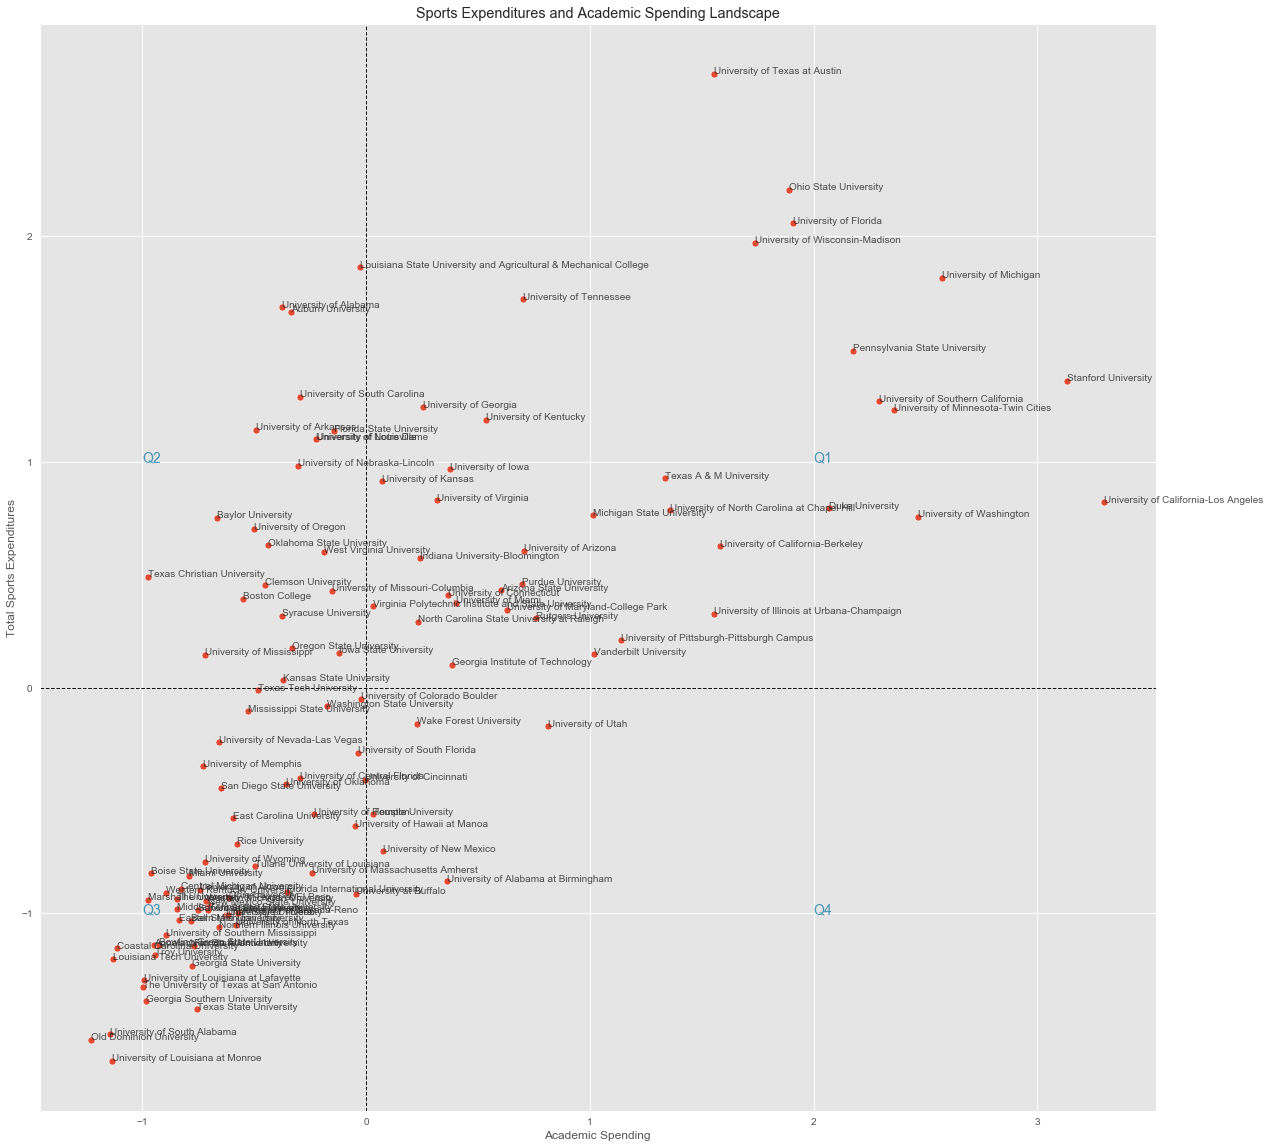

In [14]:
#repurposed code from https://github.com/hashABCD/Publications/blob/main/Medium/Quadrant%20Analysis.ipynb

plt.figure(figsize=(20,20))
plt.style.use('ggplot')
sns.scatterplot(data=school_expenditures_group_norm, x='Total Academic Spending (University-Wide)', y='Grand Total Expenses')

#Title and labels
plt.title('Sports Expenditures and Academic Spending Landscape')
plt.xlabel('Academic Spending')
plt.ylabel('Total Sports Expenditures')

#Country names
for i in range(school_expenditures_group_norm.shape[0]):
          plt.text(school_expenditures_group_norm['Total Academic Spending (University-Wide)'][i], 
                   y=school_expenditures_group_norm['Grand Total Expenses'][i], 
                   s=school_expenditures_group_norm.index[i], alpha=0.8)

#Quadrant Marker          
plt.text(x=2, y=-1, s="Q4",alpha=0.7,fontsize=14, color='b')
plt.text(x=-1, y=-1, s="Q3",alpha=0.7,fontsize=14, color='b')
plt.text(x=-1, y=1, s="Q2", alpha=0.7,fontsize=14, color='b')
plt.text(x=2, y=1, s="Q1", alpha=0.7,fontsize=14, color='b')          

#Mean values          
plt.axhline(y=school_expenditures_group_norm['Grand Total Expenses'].mean(), color='k', linestyle='--', linewidth=1)           
plt.axvline(x=school_expenditures_group_norm['Total Academic Spending (University-Wide)'].mean(), color='k',linestyle='--', linewidth=1) 
          
plt.savefig('blog_2.png')
plt.show()

Using a quadrant graph above, we can see what schools are spending more or less on sports and academics as compared to their peers. 0 is the average, so schools in Q1 are spending above average in athletics and academics. Schools like Michigan, UCLA, Ohio State, and Stanford, are leading the pack in both sports and academic expenditures.

Schools that fall in Q3 are generally smaller schools with smaller budgets, like East Carolina University and Rice. Schools in Q2 spend above average in sports, but below average in academics as compared to the rest. We see some traditional football powerhouses, like Clemson, Alabama, and Baylor on this side of the graph. Moving forward, it'll be interesting to see if schools prioritizing sports expenditures over academic spending end up hurting their students' outcomes over the medium to long run.

In [15]:
school_expenditures_group.corr()

Total Academic Spending (University-Wide)  \
Total Academic Spending (University-Wide)                                   1.000000   
Grand Total Expenses                                                        0.690049   

                                           Grand Total Expenses  
Total Academic Spending (University-Wide)              0.690049  
Grand Total Expenses                                   1.000000

Let's take a look at the top 10 sports spenders and top 10 academic spenders:

In [16]:
school_sports_group.sort_values(by = 'Grand Total Expenses', ascending = False).head(10)

INSTNM  \
134                      University of Texas at Austin   
40                               Ohio State University   
87                               University of Florida   
140                    University of Wisconsin-Madison   
27   Louisiana State University and Agricultural & ...   
107                             University of Michigan   
133                            University of Tennessee   
73                               University of Alabama   
2                                    Auburn University   
45                       Pennsylvania State University   

              FBS Conference  Grand Total Expenses  
134        Big 12 Conference           806209070.0  
40        Big Ten Conference           714172167.0  
87   Southeastern Conference           687489018.0  
140       Big Ten Conference           671998381.0  
27   Southeastern Conference           652661070.0  
107       Big Ten Conference           644125540.0  
133  Southeastern Conference           627137554.0  
73   Southeastern Conference           620799663.0  
2    Southeastern Conference           616976142.0  
45        Big Ten Conference           586066159.0

In [17]:
school_academic_group.sort_values(by = 'Total Academic Spending (University-Wide)', ascending = False).head(10)

INSTNM             FBS Conference  \
78   University of California-Los Angeles      Pacific-12 Conference   
53                    Stanford University      Pacific-12 Conference   
107                University of Michigan         Big Ten Conference   
139              University of Washington      Pacific-12 Conference   
108   University of Minnesota-Twin Cities         Big Ten Conference   
131     University of Southern California      Pacific-12 Conference   
45          Pennsylvania State University         Big Ten Conference   
12                        Duke University  Atlantic Coast Conference   
87                  University of Florida    Southeastern Conference   
40                  Ohio State University         Big Ten Conference   

     Total Academic Spending (University-Wide)  
78                                1.949101e+10  
53                                1.878749e+10  
107                               1.641962e+10  
139                               1.597102e+10  
108                               1.551876e+10  
131                               1.523084e+10  
45                                1.474232e+10  
12                                1.428856e+10  
87                                1.359673e+10  
40                                1.352496e+10

Looking at the scatter plot, we definitely see a strong, positive correlation between sports expenditures and academic spending. This makes sense because schools that can afford large sports budgets likely have larger budgets university-wide. However, there are some differences between the groups of schools, which may indicate how university adminstrations prioritize their spending.

For example, LSU, Auburn, and Alabama are top 10 in sports expenditures, but spend much less proportionately on academics. Conversely, schools like Michigan, Ohio State, and Penn State, are in both top 10 lists. 

Let's take a look at what schools produce the best earnings of its graduates and if there's any correlation with sports spending or academics spending.

In [18]:
school_earnings_group = pd.DataFrame(ncaa_df.groupby('INSTNM').agg({'6yr_mean_earnings':'mean',
                                                                 }))
#as_index=False
school_earnings_group.reset_index(inplace = True)
fig = px.histogram(school_earnings_group, x="6yr_mean_earnings", 
                  title = 'Total Sports Expenditures, 2009 - 2014')
fig.show()

So we only have two outliers, Duke and Stanford, coming in at over $80K for average 6 year earnings. The rest are concentrated between 40K and 60K. Let's create a scatter plot to look at theses earnings in comparison too sports expenditures and academic spending.

In [19]:
school_earnings_sports_group = pd.DataFrame(ncaa_df.groupby('INSTNM').agg({'6yr_mean_earnings':'mean',
                                                                 'Grand Total Expenses':'sum'}))
#as_index=False
school_earnings_sports_group.reset_index(inplace = True)
fig = px.scatter(school_earnings_sports_group, x='Grand Total Expenses', y = '6yr_mean_earnings',
                 color = 'INSTNM',
                  title = 'Avg. 6 year mean earnings and Sports Expenditures, 2009 - 2014')
fig.show()

In [20]:
school_earnings_sports_group_norm = school_earnings_sports_group.copy()
school_earnings_sports_group_norm.set_index('INSTNM', inplace = True)

school_earnings_sports_group_norm = school_earnings_sports_group_norm.apply(normalize)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


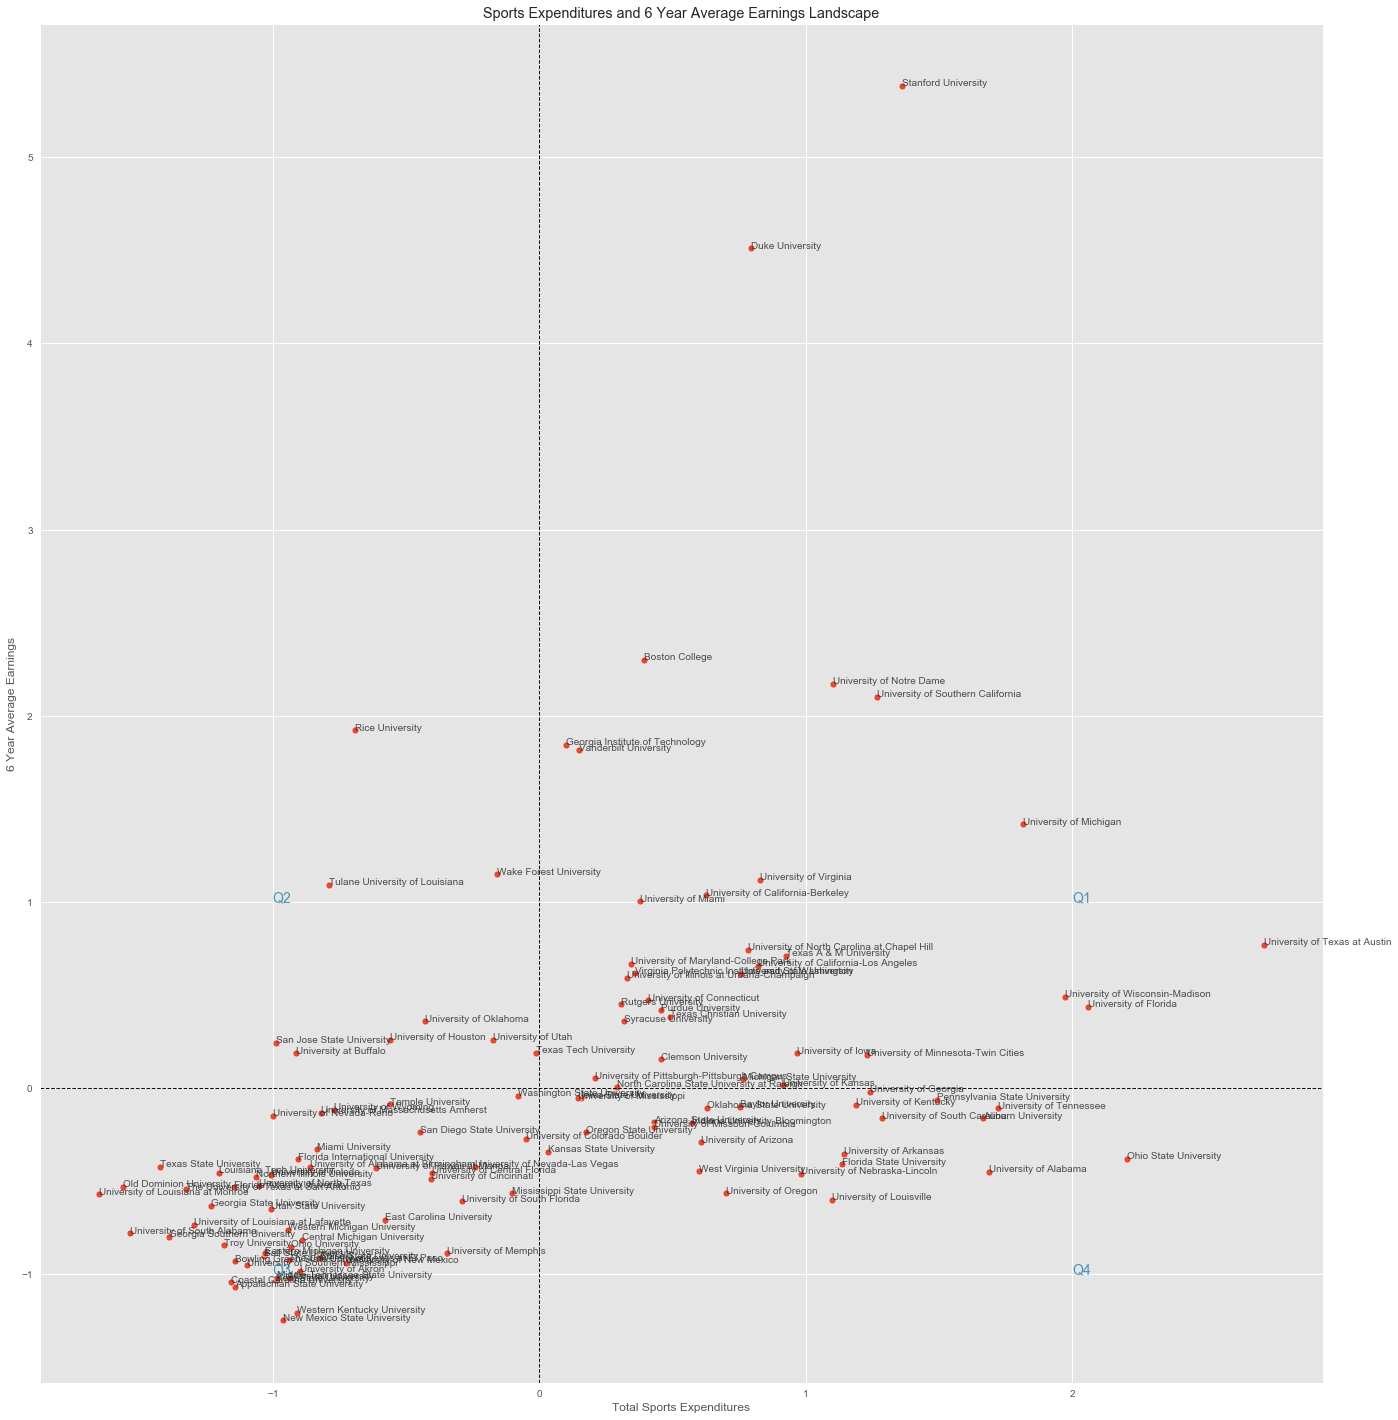

In [21]:
plt.figure(figsize=(23,25))
plt.style.use('ggplot')
sns.scatterplot(data=school_earnings_sports_group_norm, x='Grand Total Expenses', y='6yr_mean_earnings')

#Title and labels
plt.title('Sports Expenditures and 6 Year Average Earnings Landscape')
plt.xlabel('Total Sports Expenditures')
plt.ylabel('6 Year Average Earnings')

#Country names
for i in range(school_earnings_sports_group_norm.shape[0]):
          plt.text(school_earnings_sports_group_norm['Grand Total Expenses'][i], 
                   y=school_earnings_sports_group_norm['6yr_mean_earnings'][i], 
                   s=school_earnings_sports_group_norm.index[i], alpha=0.8)

#Quadrant Marker          
plt.text(x=2, y=-1, s="Q4",alpha=0.7,fontsize=14, color='b')
plt.text(x=-1, y=-1, s="Q3",alpha=0.7,fontsize=14, color='b')
plt.text(x=-1, y=1, s="Q2", alpha=0.7,fontsize=14, color='b')
plt.text(x=2, y=1, s="Q1", alpha=0.7,fontsize=14, color='b')          

#Mean values          
plt.axhline(y=school_earnings_sports_group_norm['6yr_mean_earnings'].mean(), color='k', linestyle='--', linewidth=1)           
plt.axvline(x=school_earnings_sports_group_norm['Grand Total Expenses'].mean(), color='k',linestyle='--', linewidth=1) 
          
plt.savefig('blog_2.png')
plt.show()

Looking at this quadrant graph, in Q2, we see some of the smaller schools, with below average spending, actually have above average 6 year earnings. This includes schools like Rice, Tulane, and San Jose State. The most interesting quadrant is Q4, where we have schools that spent above on sports expenditures, but have students with below average earnings. This quadrant includes schools like Alabama, Ohio State, Florida State, Arizona, and Penn State. Interestingly, Penn State and Ohio State are above average spenders on academics as well, but are still producing below average earnings. We'll explore to what effect, if any, does sports expenditures have on earnings.

In [22]:
school_earnings_sports_group.corr()

6yr_mean_earnings  Grand Total Expenses
6yr_mean_earnings                1.0000                0.4609
Grand Total Expenses             0.4609                1.0000

In [23]:
school_earnings_academics_group = pd.DataFrame(ncaa_df.groupby('INSTNM').agg({'6yr_mean_earnings':'mean',
                                                                 'Total Academic Spending (University-Wide)':'sum'}))
#as_index=False
school_earnings_academics_group.reset_index(inplace = True)
fig = px.scatter(school_earnings_academics_group, x='Total Academic Spending (University-Wide)', y = '6yr_mean_earnings',
                  title = 'Avg. 6 year mean earnings and Academic Expenditures, 2009 - 2014')
fig.show()

In [24]:
school_earnings_academics_group.corr()

6yr_mean_earnings  \
6yr_mean_earnings                                   1.000000   
Total Academic Spending (University-Wide)           0.614788   

                                           Total Academic Spending (University-Wide)  
6yr_mean_earnings                                                           0.614788  
Total Academic Spending (University-Wide)                                   1.000000

Unsurprisngly, we see a stronger correlation between academic spending and 6 year average earnings. Let's look at the top 10 average earning schools.

In [25]:
earnings = school_earnings_group.sort_values('6yr_mean_earnings', ascending = False).reset_index()
earnings.drop(columns = 'index', inplace = True)
display(earnings.head(10))

earnings[(earnings['INSTNM'] == 'University of Alabama') | (earnings['INSTNM'] == 'University of Tennessee') | (earnings['INSTNM'] == 'Auburn University') | (earnings['INSTNM'] == 'University of Texas at Austin')]

INSTNM  6yr_mean_earnings
0                Stanford University            95775.0
1                    Duke University            87050.0
2                     Boston College            64925.0
3           University of Notre Dame            63650.0
4  University of Southern California            62950.0
5                    Rice University            61150.0
6    Georgia Institute of Technology            60375.0
7              Vanderbilt University            60075.0
8             University of Michigan            56100.0
9             Wake Forest University            53400.0

INSTNM  6yr_mean_earnings
14  University of Texas at Austin            49625.0
51        University of Tennessee            40825.0
55              Auburn University            40300.0
75          University of Alabama            37425.0

Of the schools in the top 10 of sports expenditures, only Michigan produces earnings in the top 10. Alabama, which spends the 8th most on sports, is ranked 76th in 6 year average earnings. On the other hand, UT at Austin spends the most on sports but is ranked 15th in average earnings, likely because the school is ranked 11th in academic spending. In dollar terms, this equates to a nearly $12K difference in average earnings.

Now let's look at earnings by gender. We know that women receive only percentage of what mean earn in the workplace, but does university spending have any connection to how men and women perform upon graduating? Can schools shrink the gap by spending more in places than others?

In [26]:
school_earnings_male_sports_group = pd.DataFrame(prediction_df.groupby('INSTNM').agg({'6yr_male_mean_earnings':'mean',
                                                                 'Grand Total Expenses':'sum'}))
#as_index=False
school_earnings_male_sports_group.reset_index(inplace = True)
fig = px.scatter(school_earnings_male_sports_group, x='Grand Total Expenses', y = '6yr_male_mean_earnings',
                  title = 'Avg. 6 year male mean earnings and Sports Expenditures, 2009 - 2014')
fig.show()

In [27]:
school_earnings_female_sports_group = pd.DataFrame(prediction_df.groupby('INSTNM').agg({'6yr_female_mean_earnings':'mean',
                                                                 'Grand Total Expenses':'sum'}))

school_earnings_female_sports_group.reset_index(inplace = True)

fig = px.scatter(school_earnings_female_sports_group, x='Grand Total Expenses', y = '6yr_female_mean_earnings',
                  title = 'Avg. 6 year female mean earnings and Sports Expenditures, 2009 - 2014')
fig.show()

In [28]:
school_earnings_male_academic_group = pd.DataFrame(prediction_df.groupby('INSTNM').agg({'6yr_male_mean_earnings':'mean',
                                                                 'Total Academic Spending (University-Wide)':'sum'}))
#as_index=False
school_earnings_male_academic_group.reset_index(inplace = True)
fig = px.scatter(school_earnings_male_academic_group, x='Total Academic Spending (University-Wide)', 
                 y = '6yr_male_mean_earnings',
                  title = 'Avg. 6 year male mean earnings and Academic Expenditures, 2009 - 2014')
fig.show()

In [29]:
school_earnings_female_academic_group = pd.DataFrame(prediction_df.groupby('INSTNM').agg({'6yr_female_mean_earnings':'mean',
                                                                 'Total Academic Spending (University-Wide)':'sum'}))
#as_index=False
school_earnings_female_academic_group.reset_index(inplace = True)
fig = px.scatter(school_earnings_female_academic_group, x='Total Academic Spending (University-Wide)', 
                 y = '6yr_female_mean_earnings',
                  title = 'Avg. 6 year female mean earnings and Academic Expenditures, 2009 - 2014')
fig.show()

In [30]:
school_earnings_male_sports_group.corr()

6yr_male_mean_earnings  Grand Total Expenses
6yr_male_mean_earnings                1.000000              0.439589
Grand Total Expenses                  0.439589              1.000000

In [31]:
school_earnings_female_sports_group.corr()

6yr_female_mean_earnings  Grand Total Expenses
6yr_female_mean_earnings                  1.000000              0.474252
Grand Total Expenses                      0.474252              1.000000

In [32]:
school_earnings_male_academic_group.corr()

6yr_male_mean_earnings  \
6yr_male_mean_earnings                                   1.000000   
Total Academic Spending (University-Wide)                0.595898   

                                           Total Academic Spending (University-Wide)  
6yr_male_mean_earnings                                                      0.595898  
Total Academic Spending (University-Wide)                                   1.000000

In [33]:
school_earnings_female_academic_group.corr()

6yr_female_mean_earnings  \
6yr_female_mean_earnings                                   1.000000   
Total Academic Spending (University-Wide)                  0.614876   

                                           Total Academic Spending (University-Wide)  
6yr_female_mean_earnings                                                    0.614876  
Total Academic Spending (University-Wide)                                   1.000000

It appears as though female earnings fluctuate slighlty more with spending than male earnings do, although not by much. Female earnings are of a smaller magnitude, so they may be more elastic than male earnings. Any increase in school spending would have a greater impact on female post-graduate earnings than it would on the male students.

In [34]:
school_earnings_male_group = pd.DataFrame(prediction_df.groupby('INSTNM').agg({'6yr_male_mean_earnings':'mean',
                                                                 }))
school_earnings_female_group = pd.DataFrame(prediction_df.groupby('INSTNM').agg({'6yr_female_mean_earnings':'mean',
                                                                 }))

In [35]:
male_earnings = school_earnings_male_group.sort_values('6yr_male_mean_earnings', ascending = False).head(10)
male_earnings

6yr_male_mean_earnings
INSTNM                                                   
Duke University                                    111600
Stanford University                                109200
Rice University                                     79000
University of Notre Dame                            78700
Wake Forest University                              73800
Vanderbilt University                               72400
Boston College                                      71300
Georgia Institute of Technology                     68800
University of Southern California                   68700
University of Virginia                              66500

In [36]:
female_earnings = school_earnings_female_group.sort_values('6yr_female_mean_earnings', ascending = False).head(10)
female_earnings

6yr_female_mean_earnings
INSTNM                                                     
Duke University                                       76100
Stanford University                                   75800
Boston College                                        58900
Georgia Institute of Technology                       58800
University of Notre Dame                              58500
University of Southern California                     54900
Rice University                                       53600
Vanderbilt University                                 52200
Wake Forest University                                50900
University of Miami                                   50300

We have nearly identical lists, with just Miami and Virginia differing between mens and womens earnings. The pay gap is clear in these lists. Male earnings at Virigina are larger than female earnings at all but two schools in the female top 10 list. Further analysis will be done in this notebook to see what features have the largest impact on male and female earnings.

Next, let's look at if schools that spend more on women's sports have better earnings outcomes amongst its female graduates

In [37]:
school_earnings_female_support_group = pd.DataFrame(prediction_df.groupby('INSTNM').agg({'6yr_female_mean_earnings':'mean',
                                                " Women's Team Average Annual Institutional Salary per Head Coach":'mean',
                                                  "Women's Team Average Annual Institutional Salary per FTE":'mean',
                                                  "Women's Team Athletic Student Aid":'mean',
                                                    "Total Women's Team Operating Expenses":'mean',
                                                ' Womens_opex_per_participant ':'mean'
                                                                                         }))
#as_index=False
school_earnings_female_support_group.reset_index(inplace = True)

X_cols =  [c for c in school_earnings_female_support_group.columns.to_list() if c not in ['INSTNM','6yr_female_mean_earnings']]

for col in X_cols:
    fig = px.scatter(school_earnings_female_support_group, x=col, 
                 y = '6yr_female_mean_earnings',
                  title = 'Avg. 6 year female mean earnings and' + ' ' + col + ' ' + '2009 - 2014')
    fig.show()

In [38]:
school_earnings_female_support_group.corr()

6yr_female_mean_earnings  \
6yr_female_mean_earnings                                            1.000000   
 Women's Team Average Annual Institutional Sala...                  0.438073   
Women's Team Average Annual Institutional Salar...                  0.449611   
Women's Team Athletic Student Aid                                   0.693509   
Total Women's Team Operating Expenses                               0.380033   
 Womens_opex_per_participant                                        0.257935   

                                                     Women's Team Average Annual Institutional Salary per Head Coach  \
6yr_female_mean_earnings                                                                     0.438073                  
 Women's Team Average Annual Institutional Sala...                                           1.000000                  
Women's Team Average Annual Institutional Salar...                                           0.990128                  
Women's Team Athletic Student Aid                                                            0.574087                  
Total Women's Team Operating Expenses                                                        0.741157                  
 Womens_opex_per_participant                                                                 0.722622                  

                                                    Women's Team Average Annual Institutional Salary per FTE  \
6yr_female_mean_earnings                                                                     0.449611          
 Women's Team Average Annual Institutional Sala...                                           0.990128          
Women's Team Average Annual Institutional Salar...                                           1.000000          
Women's Team Athletic Student Aid                                                            0.585120          
Total Women's Team Operating Expenses                                                        0.749117          
 Womens_opex_per_participant                                                                 0.736643          

                                                    Women's Team Athletic Student Aid  \
6yr_female_mean_earnings                                                     0.693509   
 Women's Team Average Annual Institutional Sala...                           0.574087   
Women's Team Average Annual Institutional Salar...                           0.585120   
Women's Team Athletic Student Aid                                            1.000000   
Total Women's Team Operating Expenses                                        0.669506   
 Womens_opex_per_participant                                                 0.436896   

                                                    Total Women's Team Operating Expenses  \
6yr_female_mean_earnings                                                         0.380033   
 Women's Team Average Annual Institutional Sala...                               0.741157   
Women's Team Average Annual Institutional Salar...                               0.749117   
Women's Team Athletic Student Aid                                                0.669506   
Total Women's Team Operating Expenses                                            1.000000   
 Womens_opex_per_participant                                                     0.828647   

                                                     Womens_opex_per_participant   
6yr_female_mean_earnings                                                 0.257935  
 Women's Team Average Annual Institutional Sala...                       0.722622  
Women's Team Average Annual Institutional Salar...                       0.736643  
Women's Team Athletic Student Aid                                        0.436896  
Total Women's Team Operating Expenses                                    0.828647  
 Womens_opex_per_participant                                             1.000000

With all of the women's sports-specific features, we see a positive, linear relationship with average 6 year female earnings. The variable that has the strongest correlation is Women's team athletic student aid. What should be noted is that average female earnings are strongly correlated (.61) with total academic spending, and slightly less so with total sports expenditures (.47).

It is encouraging however, to see that schools willing to support their female students (and student-athletes) more result in female graduates earning more after they graduate. As mentioned earlier, we'll run regression analysis specifically on men's and women's earnings to try to narrow down causal relationships.

Now, let's take a look at how sports expenses relate to debt loads, and how debt loads relate to earnings

In [39]:
ncaa_df.columns.to_list()

['IPEDS_ID',
 'INSTNM',
 'Year',
 'NCAA Subdivision',
 'FBS Conference',
 'Excess Transfers Back',
 'Other Expenses',
 'Medical',
 'Competition Guarantees',
 'Recruiting',
 'Game Expenses and Travel',
 'Facilities and Equipment',
 'Coaches Compensation',
 'Support and Admin Compensation w/Severance',
 'Athletic Student Aid',
 'Other Revenue',
 'Corporate Sponsorship, Advertising, Licensing',
 'Donor Contributions',
 'Competition Guarantees_revenue',
 'NCAA/Conference Distributions, Media Rights, and Post-Season Football',
 'Ticket Sales',
 'Institutional/Government Support',
 'Student Fees',
 'Total Institutional/Government Support and Student Fees',
 'Total Academic Spending (University-Wide)',
 'Total Football Spending',
 'Total Football Coaching Salaries',
 'Athletics Related Debt',
 'Annual Debt Service, Leases and Rental Fees on Athletic Facilities',
 'State CD',
 'Classification Name',
 'Sanction Name',
 'Male Undergraduates',
 'Female Undergraduates',
 'Total Undergraduates',
 '

In [40]:
debt_to_earnings_group = pd.DataFrame(prediction_df.groupby('INSTNM').agg({'6yr_mean_earnings':'mean',
                                                'pct_revenue_from_students':'mean',
                                                 'tuition_rev_per_student':'mean',
                                                  'fed_loan_rate':'mean',
                                                  'median_male_debt':'mean',
                                                    'median_debt_completers':'mean',
                                                'median_loan_principal':'mean',
                                                'avg_annual_cost_attendance':'mean',
                                                'CUML_DEBT_P90':'mean',
                                               'Grand Total Expenses':'sum'}))
#as_index=False
debt_to_earnings_group.reset_index(inplace = True)

X_cols =  [c for c in debt_to_earnings_group.columns.to_list() if c not in ['INSTNM','6yr_mean_earnings']]

#first mean earnings
for col in X_cols:
    fig = px.scatter(debt_to_earnings_group, x=col, 
                 y = '6yr_mean_earnings',
                  title = 'Avg. 6 year mean earnings and' + ' ' + col + ' ' + '2009 - 2014')
    fig.show()

In [41]:
debt_to_earnings_group.corr()

6yr_mean_earnings  pct_revenue_from_students  \
6yr_mean_earnings                    1.000000                  -0.334801   
pct_revenue_from_students           -0.334801                   1.000000   
tuition_rev_per_student              0.699340                  -0.371392   
fed_loan_rate                       -0.623857                   0.389584   
median_male_debt                     0.219186                  -0.207061   
median_debt_completers              -0.455785                   0.071917   
median_loan_principal                0.172544                  -0.176398   
avg_annual_cost_attendance           0.733156                  -0.229312   
CUML_DEBT_P90                       -0.487523                   0.170094   
Grand Total Expenses                 0.460158                  -0.590243   

                            tuition_rev_per_student  fed_loan_rate  \
6yr_mean_earnings                          0.699340      -0.623857   
pct_revenue_from_students                 -0.371392       0.389584   
tuition_rev_per_student                    1.000000      -0.391583   
fed_loan_rate                             -0.391583       1.000000   
median_male_debt                           0.503258       0.115541   
median_debt_completers                     0.002935       0.674667   
median_loan_principal                      0.475545       0.173385   
avg_annual_cost_attendance                 0.878120      -0.379051   
CUML_DEBT_P90                             -0.199852       0.626061   
Grand Total Expenses                       0.421565      -0.435711   

                            median_male_debt  median_debt_completers  \
6yr_mean_earnings                   0.219186               -0.455785   
pct_revenue_from_students          -0.207061                0.071917   
tuition_rev_per_student             0.503258                0.002935   
fed_loan_rate                       0.115541                0.674667   
median_male_debt                    1.000000                0.564977   
median_debt_completers              0.564977                1.000000   
median_loan_principal               0.986735                0.627998   
avg_annual_cost_attendance          0.366298               -0.115313   
CUML_DEBT_P90                       0.136134                0.696863   
Grand Total Expenses                0.395350               -0.091294   

                            median_loan_principal  avg_annual_cost_attendance  \
6yr_mean_earnings                        0.172544                    0.733156   
pct_revenue_from_students               -0.176398                   -0.229312   
tuition_rev_per_student                  0.475545                    0.878120   
fed_loan_rate                            0.173385                   -0.379051   
median_male_debt                         0.986735                    0.366298   
median_debt_completers                   0.627998                   -0.115313   
median_loan_principal                    1.000000                    0.345623   
avg_annual_cost_attendance               0.345623                    1.000000   
CUML_DEBT_P90                            0.205988                   -0.183218   
Grand Total Expenses                     0.361801                    0.270159   

                            CUML_DEBT_P90  Grand Total Expenses  
6yr_mean_earnings               -0.487523              0.460158  
pct_revenue_from_students        0.170094             -0.590243  
tuition_rev_per_student         -0.199852              0.421565  
fed_loan_rate                    0.626061             -0.435711  
median_male_debt                 0.136134              0.395350  
median_debt_completers           0.696863             -0.091294  
median_loan_principal            0.205988              0.361801  
avg_annual_cost_attendance      -0.183218              0.270159  
CUML_DEBT_P90                    1.000000             -0.357981  
Grand Total Expenses            -0.357981              1.000000

6 year average earnings have some interesting and illustrative relationships with these cost of attendance and debt variables. Generally, earnings have negative relationships with debt features, like the federal loan rate, the median debt of graduates, and the cumulative debt in the 90th percentile. It also has somewhat strong positive relationships with the cost of attendance and total athletic expenses. These positive relationships could be the result of these variables signaling the overall resources a school has. A more expensive school likely has better resources, however we see that tuition revenue per student is positively correlated with median debt and median loan principal, possibly indicating that students who owe more in tuition are forced to take out larger loans.

In [42]:
sports_expeneses_debt_group = pd.DataFrame(prediction_df.groupby('INSTNM').agg({'Grand Total Expenses':'mean',
                                                                    'median_male_debt':'mean',
                                                                    'median_debt_completers':'mean',
                                                                    'median_loan_principal':'mean',
                                                                    'avg_annual_cost_attendance':'mean',
                                                                    'CUML_DEBT_P90':'mean',}))
#as_index=False
sports_expeneses_debt_group.reset_index(inplace = True)
fig = px.scatter(sports_expeneses_debt_group, x='Grand Total Expenses', 
                 y = 'median_male_debt',
                  title = 'Avg. median male debt and total sports expenditures, 2009 - 2014')
fig.show()

In [43]:
sports_expeneses_debt_group.corr()

Grand Total Expenses  median_male_debt  \
Grand Total Expenses                    1.000000          0.395350   
median_male_debt                        0.395350          1.000000   
median_debt_completers                 -0.091294          0.564977   
median_loan_principal                   0.361801          0.986735   
avg_annual_cost_attendance              0.270159          0.366298   
CUML_DEBT_P90                          -0.357981          0.136134   

                            median_debt_completers  median_loan_principal  \
Grand Total Expenses                     -0.091294               0.361801   
median_male_debt                          0.564977               0.986735   
median_debt_completers                    1.000000               0.627998   
median_loan_principal                     0.627998               1.000000   
avg_annual_cost_attendance               -0.115313               0.345623   
CUML_DEBT_P90                             0.696863               0.205988   

                            avg_annual_cost_attendance  CUML_DEBT_P90  
Grand Total Expenses                          0.270159      -0.357981  
median_male_debt                              0.366298       0.136134  
median_debt_completers                       -0.115313       0.696863  
median_loan_principal                         0.345623       0.205988  
avg_annual_cost_attendance                    1.000000      -0.183218  
CUML_DEBT_P90                                -0.183218       1.000000

There turns out to be weaker relationships between total sports expenditures and debt loads on students.

Let's now look at the overall distributions of 6 year average earnings in our data.

In [44]:
fig = px.histogram(prediction_df, x="6yr_mean_earnings",
                  title = '6 year mean earnings')
fig.show()

In [45]:
fig = px.histogram(prediction_df, x="6yr_female_mean_earnings",
                  title = '6 year female mean earnings')
fig.show()

In [46]:
fig = px.histogram(prediction_df, x="6yr_male_mean_earnings",
                  title = '6 year male mean earnings')
fig.show()

Earnings are right skewed, so logging our data will be useful when running regressions.

Now, let's look at some pairplots to get an idea of the distributions of our explanatory variables

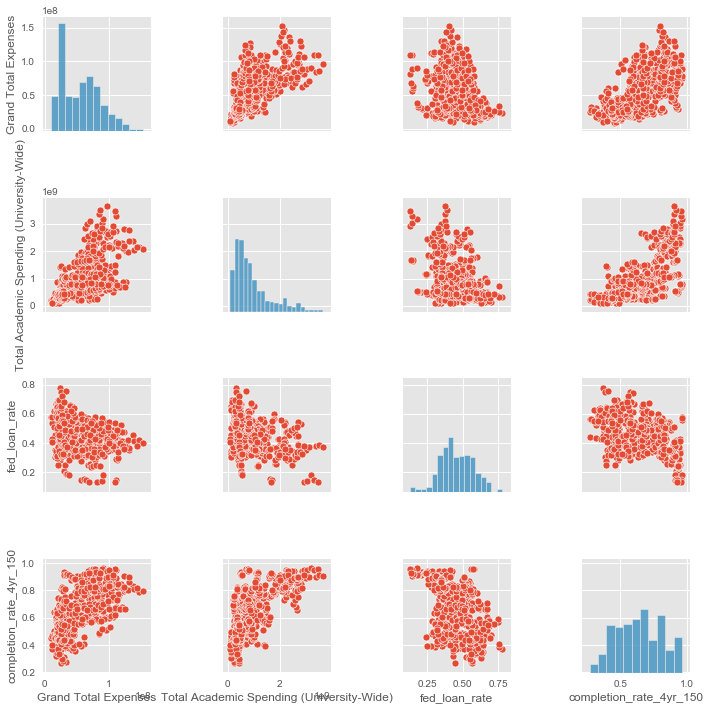

In [47]:
cols_to_use = ['Grand Total Expenses', 'Total Academic Spending (University-Wide)', 
               'fed_loan_rate','completion_rate_4yr_150']
sns.pairplot(ncaa_df[cols_to_use])

Total academic spending and total expenses have a clear positive, linear relationship, and both are also skewed to the right. We also see a positive relationship between completion rate and total sports expenses and and academic spending. More spending can be inferred as more student support, so students at wealthier schools graduate at higher rates.

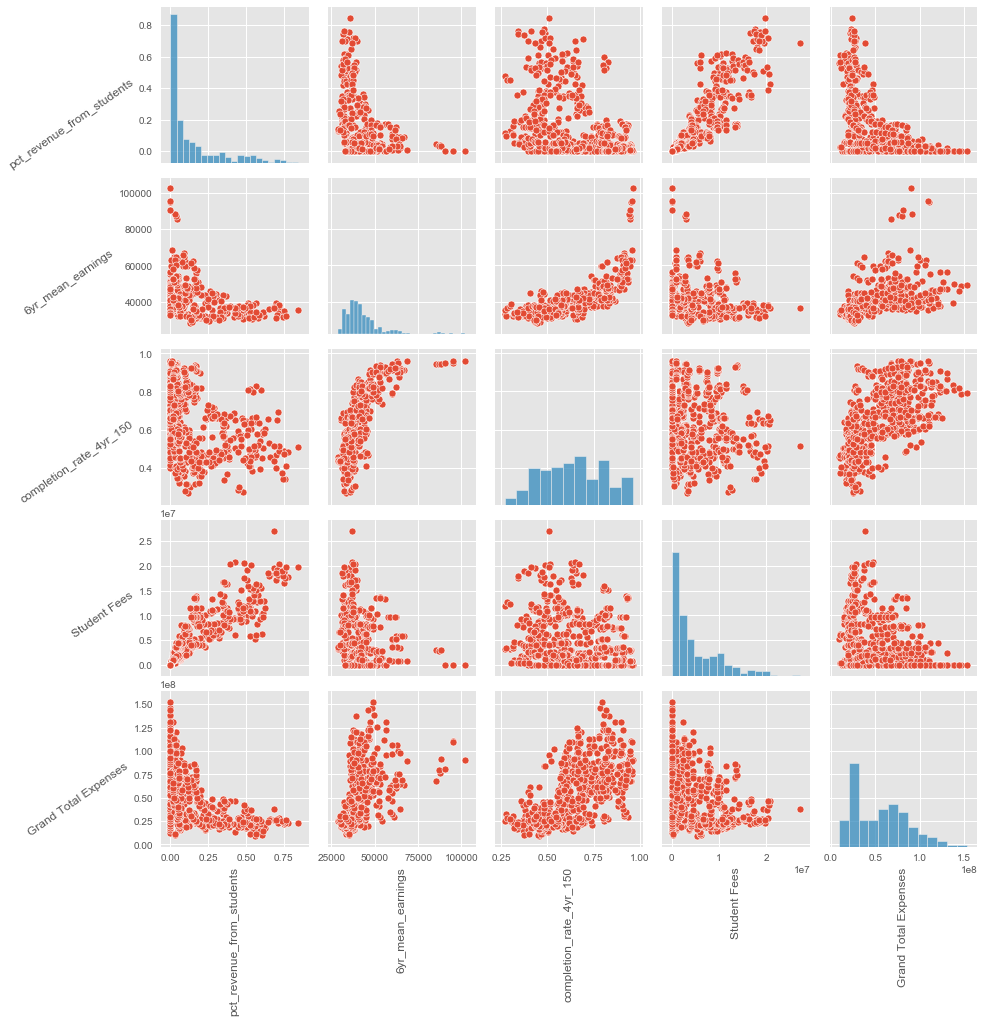

In [48]:
cols_to_use = ["pct_revenue_from_students", 
               "6yr_mean_earnings", 
               'completion_rate_4yr_150',"Student Fees",'Grand Total Expenses']
pairplot = sns.pairplot(ncaa_df[cols_to_use])
for ax in pairplot.axes.flatten():
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    # rotate y axis labels
    ax.set_ylabel(ax.get_ylabel(), rotation = 35)
    # set y labels alignment
    ax.yaxis.get_label().set_horizontalalignment('right')

## Modeling

I will take at least three different approaches to modeling this data: 

1. Using only sports-related data (expenses, participants, conference, etc.)
2. Using only non-sports data (family income, debt accumulated, cost of attendance, demographics, etc.)
3. Using a blend of both types of data

I'm taking this approach so we can isolate the effects that sports have on our target variable, 6 year mean earings. By comparing an all sports model to a no sports model, we can look at what better predicts future earnings. The 3rd model, which will use the best features overall, will likely be the most accurate predictor of future earnings.

Modeling will have two goals: producing accurate predictions of future earnings and diagnosing what features most impact future earnings, positive and negatively.

For this to work, I'll need to drop the columns from the NCAA dataset with excessive nulls. All private schools are missing the sports spending columns.

### First crappy sports-only model

In [49]:
ncaa_df.columns.to_list()

['IPEDS_ID',
 'INSTNM',
 'Year',
 'NCAA Subdivision',
 'FBS Conference',
 'Excess Transfers Back',
 'Other Expenses',
 'Medical',
 'Competition Guarantees',
 'Recruiting',
 'Game Expenses and Travel',
 'Facilities and Equipment',
 'Coaches Compensation',
 'Support and Admin Compensation w/Severance',
 'Athletic Student Aid',
 'Other Revenue',
 'Corporate Sponsorship, Advertising, Licensing',
 'Donor Contributions',
 'Competition Guarantees_revenue',
 'NCAA/Conference Distributions, Media Rights, and Post-Season Football',
 'Ticket Sales',
 'Institutional/Government Support',
 'Student Fees',
 'Total Institutional/Government Support and Student Fees',
 'Total Academic Spending (University-Wide)',
 'Total Football Spending',
 'Total Football Coaching Salaries',
 'Athletics Related Debt',
 'Annual Debt Service, Leases and Rental Fees on Athletic Facilities',
 'State CD',
 'Classification Name',
 'Sanction Name',
 'Male Undergraduates',
 'Female Undergraduates',
 'Total Undergraduates',
 '

In [50]:
#first, going to remove columns with many nulls
cols_to_drop = ['Excess Transfers Back',
 'Other Expenses',
 'Medical',
 'Competition Guarantees',
 'Recruiting',
 'Game Expenses and Travel',
 'Facilities and Equipment',
 'Coaches Compensation',
 'Support and Admin Compensation w/Severance',
 'Athletic Student Aid',
 'Other Revenue',
 'Corporate Sponsorship, Advertising, Licensing',
 'Donor Contributions',
 'Competition Guarantees_revenue',
 'NCAA/Conference Distributions, Media Rights, and Post-Season Football',
 'Ticket Sales',
 'Institutional/Government Support',
'Total Institutional/Government Support and Student Fees',
'Total Football Spending',
 'Total Football Coaching Salaries',
 'Athletics Related Debt',
 'Annual Debt Service, Leases and Rental Fees on Athletic Facilities',]

In [51]:
ncaa_df2 = ncaa_df.drop(columns = cols_to_drop)

In [52]:
#creating my grouped dataset with all features I may want to use
ncaa_grouped_sports = ncaa_df2.groupby('INSTNM', 
                    as_index=False).agg({ 'Student Fees':'sum',
                                         "Men's Team Number of Head Coaches Included in Average":'mean',
                                         "Women's Team Number of Head Coaches Included in Average":'mean',
                                         'Grand Total Revenue':'sum',
                                         'Grand Total Expenses':'sum',
                                         ' Total_expenses_men_per_participant ':'mean',
                                         'Total_expenses_women_per_participant':'mean'
                                        })

ncaa_grouped_sports['pct_revenue_from_students'] = ncaa_grouped_sports['Student Fees'] / ncaa_grouped_sports['Grand Total Revenue']

In [53]:
ncaa_grouped_sports.head()

INSTNM  Student Fees  \
0  Appalachian State University  5.586136e+07   
1      Arizona State University  0.000000e+00   
2             Auburn University  2.953605e+07   
3         Ball State University  6.298556e+07   
4             Baylor University  0.000000e+00   

   Men's Team Number of Head Coaches Included in Average  \
0                                                9.0       
1                                                7.0       
2                                                7.0       
3                                                7.0       
4                                                6.0       

   Women's Team Number of Head Coaches Included in Average  \
0                                           9.000000         
1                                          10.333333         
2                                          10.000000         
3                                          10.000000         
4                                           8.833333         

   Grand Total Revenue  Grand Total Expenses  \
0          113592089.0           113592089.0   
1          396442258.0           395625799.0   
2          652739784.0           616976142.0   
3          132898085.0           132898085.0   
4          453245247.0           453245247.0   

    Total_expenses_men_per_participant   Total_expenses_women_per_participant  \
0                          22521.333333                          16172.500000   
1                         102800.166667                          50398.500000   
2                         177108.500000                          58763.166667   
3                          41641.833333                          24534.166667   
4                         115768.500000                          43732.000000   

   pct_revenue_from_students  
0                   0.491772  
1                   0.000000  
2                   0.045249  
3                   0.473939  
4                   0.000000

In [54]:
prediction_df2 = prediction_df.drop(columns = cols_to_drop)

In [55]:
#creating separate data set with prediction columns from 2015
prediction_df_reg = prediction_df2[['INSTNM','6yr_mean_earnings','6yr_female_mean_earnings',
                                   '6yr_male_mean_earnings','6yr_median_earnings']]

In [56]:
prediction_df_reg.head()

INSTNM  6yr_mean_earnings  6yr_female_mean_earnings  \
0  Appalachian State University              34300                     32000   
1      Arizona State University              42200                     38900   
2             Auburn University              43100                     38200   
3         Ball State University              35300                     33500   
4             Baylor University              46600                     42400   

   6yr_male_mean_earnings  6yr_median_earnings  
0                   36800                33000  
1                   46000                38300  
2                   47900                39500  
3                   37400                34000  
4                   52700                42600

In [57]:
sports_merge = ncaa_grouped_sports.merge(prediction_df_reg, on='INSTNM')

In [58]:
sports_merge.columns

Index(['INSTNM', 'Student Fees',
       'Men's Team Number of Head Coaches Included in Average',
       'Women's Team Number of Head Coaches Included in Average',
       'Grand Total Revenue', 'Grand Total Expenses',
       ' Total_expenses_men_per_participant ',
       'Total_expenses_women_per_participant', 'pct_revenue_from_students',
       '6yr_mean_earnings', '6yr_female_mean_earnings',
       '6yr_male_mean_earnings', '6yr_median_earnings'],
      dtype='object')

In [59]:
from project_functions_19 import *

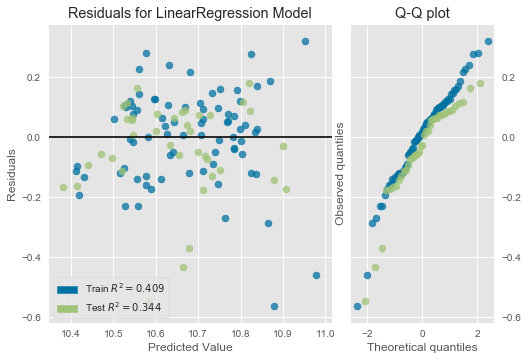

Train Score: 0.40915139161624836
Test Score: 0.3444993514664233
---
Train RMSE:  0.15472179583919973
Test RMSE:  0.15954812091993262
---
Unlogged Train RMSE:  8322.728024794216
Unlogged Test RMSE:  7977.474320380442
---


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      6yr_mean_earnings   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     5.973
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           8.20e-06
Time:                        16:08:11   Log-Likelihood:                 34.881
No. Observations:                  78   AIC:                            -51.76
Df Residuals:                      69   BIC:                            -30.55
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
const                                                      10.6763      0.019    573.183      0.000      10.639      10.713
Student Fees                                                0.0131      0.021      0.619      0.538      -0.029       0.055
Men's Team Number of Head Coaches Included in Average       0.0546      0.032      1.706      0.093      -0.009       0.118
Women's Team Number of Head Coaches Included in Average     0.0304      0.032      0.945      0.348      -0.034       0.094
Grand Total Revenue                                        -0.1642      0.297     -0.554      0.582      -0.756       0.427
Grand Total Expenses                                        0.1918      0.293      0.654      0.515      -0.393       0.777
 Total_expenses_men_per_participant                         0.0429      0.046      0.930      0.355      -0.049       0.135
Total_expenses_women_per_participant                        0.0204      0.039      0.526      0.601      -0.057       0.098
pct_revenue_from_students                                   0.0030      0.021      0.140      0.889      -0.039       0.045
==============================================================================
Omnibus:                       13.782   Durbin-Watson:                   2.221
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.980
Skew:                           0.818   Prob(JB):                     0.000205
Kurtosis:                       4.597   Cond. No.                         45.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
ms_linear_regression(sports_merge, scale = 'yes')

Our major issue here is that none of the x variables are statistically significant, likely because of multicollinearity. Additionally, the model overfits on the train data. Let's use a function to determine the collinearity of our x values.

In [61]:
ms_vif(sports_merge, nulls = 'yes')

VIF                                           features
0    6.157829                                       Student Fees
1   43.932129  Men's Team Number of Head Coaches Included in ...
2   51.341872  Women's Team Number of Head Coaches Included i...
3  235.013485                                Grand Total Revenue
4  289.073667                               Grand Total Expenses
5   30.757472                Total_expenses_men_per_participant 
6   29.818787               Total_expenses_women_per_participant
7    6.245894                          pct_revenue_from_students

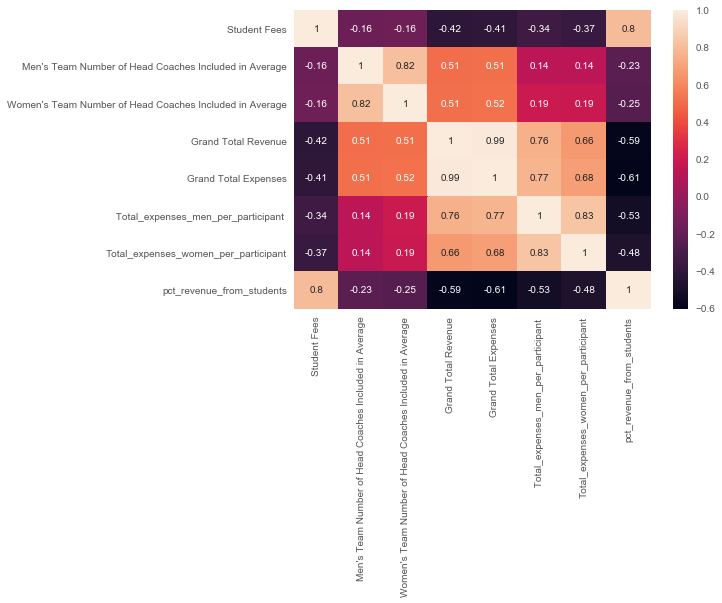

In [62]:
#let's also take a look at a heatmap of correlations
X_cols = [c for c in sports_merge.columns.to_list() if c not in ['INSTNM','6yr_mean_earnings', '6yr_female_mean_earnings',
                                                           '6yr_male_mean_earnings', '6yr_median_earnings']]
ax = sns.heatmap(sports_merge[X_cols].corr(), annot=True);
# need to manually set my ylim because of my version of matplotlib
ax.set_ylim(8, 0)
plt.show()

All variables have a VIF above 5, meaning that there is a lot of multicollinearity present in this model. Expenses are highly correlated with revenues, because, as non-profit institutions, Universities must spend all profits they make.

### First crappy non-sports-only model

In [63]:
#creating my grouped dataset with all features I may want to use
ncaa_grouped_non_sports = ncaa_df2.groupby('INSTNM', 
                    as_index=False).agg({ 'Total Academic Spending (University-Wide)':'sum',
                                        'ADM_RATE':'mean',
                                        'SAT_AVG':'sum',
                                         'avg_annual_cost_attendance':'sum',
                                         "instructional_expenditure_per_student":'mean',
                                         "fed_loan_rate":'mean',
                                         'FAMINC':'mean',
                                         'completion_rate_4yr_150':'mean',
                                         'median_debt_completers':'mean',
                                        })

In [64]:
non_sports_merge = ncaa_grouped_non_sports.merge(prediction_df_reg, on='INSTNM')

In [65]:
ms_vif(non_sports_merge, nulls = 'yes')

VIF                                   features
0    7.530147  Total Academic Spending (University-Wide)
1   17.677863                                   ADM_RATE
2   28.235212                                    SAT_AVG
3   22.441191                 avg_annual_cost_attendance
4    9.034255      instructional_expenditure_per_student
5   61.828803                              fed_loan_rate
6   64.397262                                     FAMINC
7   92.738592                    completion_rate_4yr_150
8  126.046831                     median_debt_completers

We see smaller VIF scores overall for these variables, but each score once again is over 5.

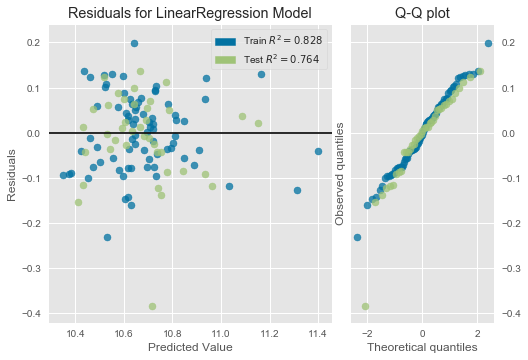

Train Score: 0.8282935089991963
Test Score: 0.7636477344511495
---
Train RMSE:  0.08340781525052811
Test RMSE:  0.09580430299160313
---
Unlogged Train RMSE:  3763.899231347773
Unlogged Test RMSE:  4713.1001182185755
---


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      6yr_mean_earnings   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     36.45
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           1.25e-22
Time:                        16:08:12   Log-Likelihood:                 83.076
No. Observations:                  78   AIC:                            -146.2
Df Residuals:                      68   BIC:                            -122.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                        10.6763      0.010   1055.524      0.000      10.656      10.696
Total Academic Spending (University-Wide)     0.0262      0.020      1.319      0.191      -0.013       0.066
ADM_RATE                                     -0.0488      0.018     -2.665      0.010      -0.085      -0.012
SAT_AVG                                      -0.0268      0.014     -1.850      0.069      -0.056       0.002
avg_annual_cost_attendance                    0.0225      0.018      1.242      0.219      -0.014       0.059
instructional_expenditure_per_student         0.0184      0.021      0.868      0.388      -0.024       0.061
fed_loan_rate                                 0.0132      0.018      0.716      0.477      -0.024       0.050
FAMINC                                        0.0853      0.023      3.756      0.000       0.040       0.131
completion_rate_4yr_150                       0.0125      0.027      0.471      0.639      -0.040       0.065
median_debt_completers                       -0.0852      0.020     -4.208      0.000      -0.126      -0.045
==============================================================================
Omnibus:                        0.418   Durbin-Watson:                   2.140
Prob(Omnibus):                  0.812   Jarque-Bera (JB):                0.581
Skew:                           0.093   Prob(JB):                        0.748
Kurtosis:                       2.621   Cond. No.                         8.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
ms_linear_regression(non_sports_merge, scale = 'yes')

This model does better across the board, with improved RMSEs and almost double the r2. However, we do have a statistical significance problem.

We do see three statistically significant features: admission rate, median debt of graduates, and family income. Family income is positive, which makes sense given that the better off your family is, the easier time you'll have getting into more expensive schools and surround yourself with the best resources to succeed.

Admission rate has a negative coefficient, meaning that as admission rate increases, future earnings decrease, and vice versa. It appears as the selectivity of school goes down, it has an overall negative impact on its students. Let's see if this continues as we further refine the model.

Let's take at look at the distributions of these variables:

In [67]:
fig = px.histogram(ncaa_grouped_non_sports, x="FAMINC",
                  title = 'Avg. Family Income')
fig.show()

In [68]:
fig = px.histogram(ncaa_grouped_non_sports, x='ADM_RATE',
                  title = 'Admission Rate')
fig.show()

Family income follows more of a normal distribution, while admission rate is left skewed - most schools have an admission rate between 60% and 80%.

Before moving on, let's look to see what sort of outliers we're working with across sports and non-sports vars:

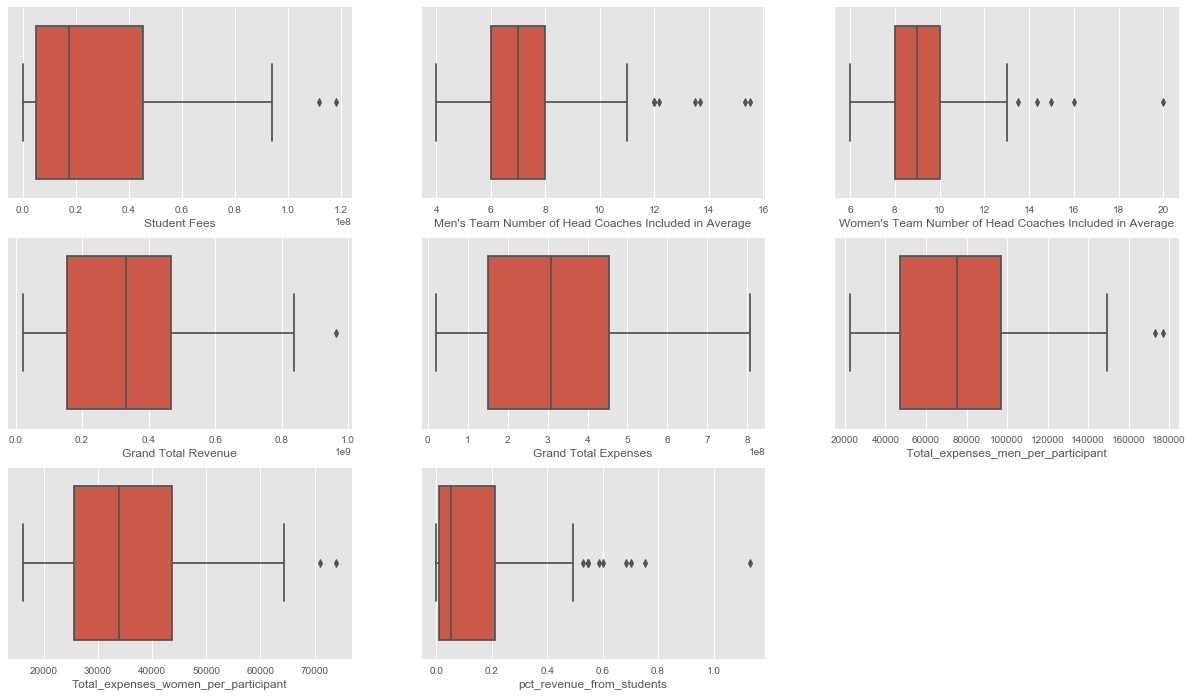

In [69]:
X_cols = [c for c in sports_merge.columns.to_list() if c not in ['INSTNM','6yr_mean_earnings', '6yr_female_mean_earnings',
                                                           '6yr_male_mean_earnings', '6yr_median_earnings']]

ms_plot_univariate_panel(X_cols, sports_merge, sns.boxplot, 3)

We have significant outliers in athletic debt, number of head coaches, and pct revenue from students. Log transforming will help smooth these outliers, but removing some at the higher end would likely improve the model.

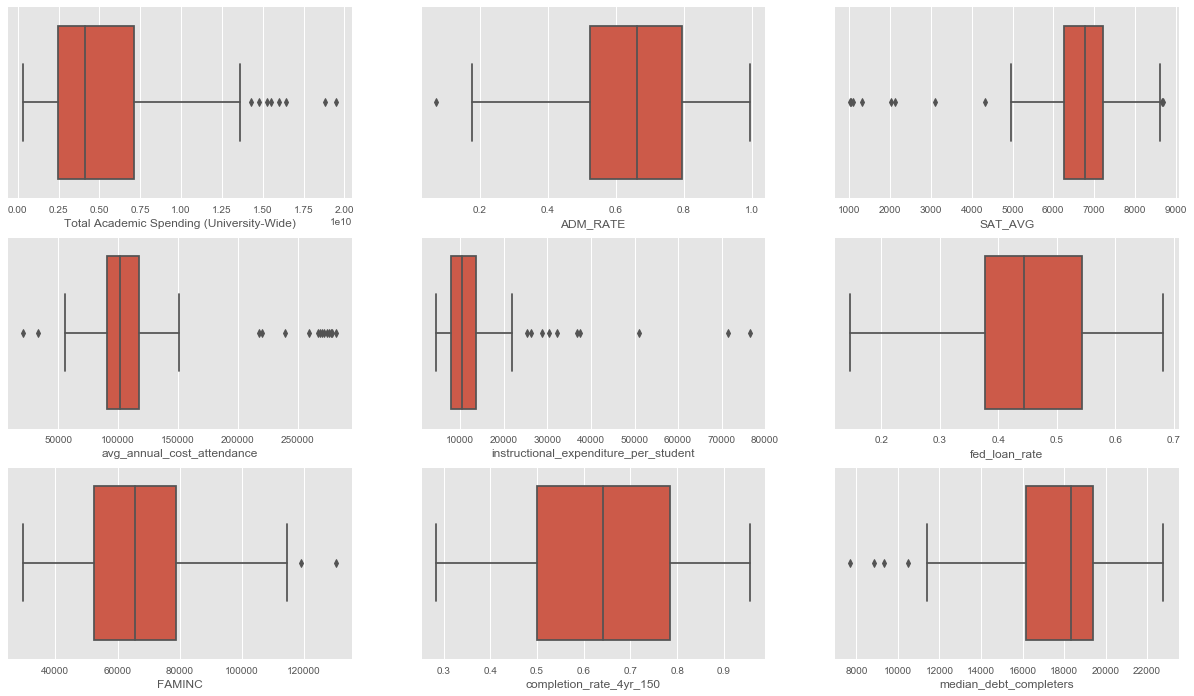

In [70]:
X_cols = [c for c in non_sports_merge.columns.to_list() if c not in ['INSTNM','6yr_mean_earnings', '6yr_female_mean_earnings',
                                                           '6yr_male_mean_earnings', '6yr_median_earnings']]
ms_plot_univariate_panel(X_cols, non_sports_merge, sns.boxplot, 3)

On the non-sports side, we have significant outliers in total academic spending, avg annual cost of attendance, instructional expenditure per student, and SAT average.

## Fine-Tuning the Models

Next, I'll try a few different models to ascertain the most impactful and useful features. I will also now log the numeric values in addition to scaling them. The three primary models I'll be using are:

- **Lasso Regression**
- **Ridge Regression**
- **ElasticNet (combination of both Ridge and Lasso Regression)**

If needed, I'll also remove outliers which negatively affect the modeling.

### Lasso Regression

[Lasso regression performs L1 regularization](https://www.statisticshowto.com/lasso-regression/), which adds a penalty equal to the absolute value of the magnitude of coefficients. This method shrinks down coefficients, some to zero, which you can then remove from the model, making our model simpler and more interpretable. This will be useful with a dataset of over 100 features.

To deal with multicollinearity, [the Lasso model gives one of the correlated features a large coefficient while the rest are zeroed or nearly zeroed.](https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net)

In [71]:
#creating a new grouped dataset with just the 2015 mean and median earnings columns
prediction_cols = ['6yr_mean_earnings', '6yr_median_earnings'] 

sum_cols_df = ncaa_df2[['INSTNM','Total Academic Spending (University-Wide)',
                                        'Grand Total Expenses',
                                        'Grand Total Revenue']]

sum_cols_grouped = sum_cols_df.groupby('INSTNM')[sum_cols_df.columns].sum()


X_cols = [c for c in ncaa_df2.columns.to_list() if c not in ['Total Academic Spending (University-Wide)',
                                        'Grand Total Expenses',
                                        'Grand Total Revenue']]

ncaa_grouped = ncaa_df2.groupby('INSTNM')[X_cols].mean().reset_index()
ncaa_grouped.drop(columns = prediction_cols, inplace = True)

ncaa_grouped_merge = ncaa_grouped.merge(prediction_df_reg, on='INSTNM')
ncaa_grouped_all_merge = ncaa_grouped_merge.merge(sum_cols_grouped, on='INSTNM' )
ncaa_grouped_all_merge.drop(columns = ['IPEDS_ID', 'Year'], inplace = True)

ncaa_grouped_all_merge.head()

INSTNM  Student Fees  Male Undergraduates  \
0  Appalachian State University  9.310227e+06          7010.166667   
1      Arizona State University  0.000000e+00         22417.000000   
2             Auburn University  4.922676e+06          9282.333333   
3         Ball State University  1.049759e+07          7062.833333   
4             Baylor University  0.000000e+00          5256.333333   

   Female Undergraduates  Total Undergraduates  Football Total Participation  \
0            7638.500000          14648.666667                    109.500000   
1           21461.333333          43878.333333                    117.666667   
2            9203.000000          18485.333333                    121.500000   
3            8764.833333          15827.666667                    119.333333   
4            7341.500000          12597.833333                    117.666667   

   Total Men's Team Participation  Total Women's Team Participation  \
0                           347.5                        239.166667   
1                           356.5                        274.833333   
2                           307.5                        281.833333   
3                           228.0                        242.000000   
4                           278.5                        379.833333   

   Men's Team Average Annual Institutional Salary per Head Coach  \
0                                       9.584050e+04               
1                                       7.983728e+05               
2                                       9.954535e+05               
3                                       1.462342e+05               
4                                       1.137027e+06               

   Men's Team Number of Head Coaches Included in Average  ...  \
0                                                9.0      ...   
1                                                7.0      ...   
2                                                7.0      ...   
3                                                7.0      ...   
4                                                6.0      ...   

   pell_grant_rate_current_academic_year  fed_loan_rate_current_academic_year  \
0                               0.195550                             0.398083   
1                               0.287167                             0.385483   
2                               0.121800                             0.310767   
3                               0.289150                             0.602850   
4                               0.204233                             0.514733   

   pct_revenue_from_students  6yr_mean_earnings  6yr_female_mean_earnings  \
0                   0.497013              34300                     32000   
1                   0.000000              42200                     38900   
2                   0.046172              43100                     38200   
3                   0.477437              35300                     33500   
4                   0.000000              46600                     42400   

   6yr_male_mean_earnings  6yr_median_earnings  \
0                   36800                33000   
1                   46000                38300   
2                   47900                39500   
3                   37400                34000   
4                   52700                42600   

   Total Academic Spending (University-Wide)  Grand Total Expenses  \
0                               1.501687e+09           113592089.0   
1                               8.074427e+09           395625799.0   
2                               4.107018e+09           616976142.0   
3                               2.204604e+09           132898085.0   
4                               2.700782e+09           453245247.0   

   Grand Total Revenue  
0          113592089.0  
1          396442258.0  
2          652739784.0  
3          132898085.0  
4          453245247.0  

[5 rows x 101 columns]

In [72]:
lasso_model, cols = ms_lasso_regression(ncaa_grouped_all_merge, scale = 'yes')

Train R2: 0.9613143241124343
Test R2: 0.8706652122956692
*****
Train MSE: 0.0015673896227838234
Test MSE: 0.005022565580843139
*****
Train RMSE: 0.03959027182002952
Test RMSE: 0.07087006124481013
None


In [73]:
lasso_coefs = ms_eval_coefficients(lasso_model, cols)

Total number of coefficients:  94
Coefficients close to zero:  55
Intercept: 10.676291138768727


avg_annual_cost_attendance         0.068706
LOAN_EVER                          0.039499
1yr_declining_loan_balance         0.035905
pct_asian                          0.026992
median_female_debt                 0.022542
                                     ...   
pct_women                         -0.022311
PELL_EVER                         -0.027005
num_male_4yr_completers           -0.031276
Men's Team Athletic Student Aid   -0.038798
median_debt_completers            -0.084023
Length: 94, dtype: float64

With the Lasso model, the data was slightly overfit on the training data, but the r2 values are both above .8. The model also shrunk 55 columns to zero, or close to zero, meaning we can drop these coefficients from the model. These coefficients are less important, either because they are correlated with a more powerful variable, or they themselves are only weakly related to the dependent variable, which in our case is 6 year mean earnings.

Let's now use these coefficients in a ridge regression model.

### Ridge Regression

Ridge regression helps shrink large coefficients by adding a penalty term to the square of the magnitude of the coefficients. Large coefficients penalize the optimation function. The shrinkage helps reduce model complexity and multicollinearity. Ridge regression assumes the predictors are scaled, so we'll be sure to scale the X variables. 

To deal with multicollinearity, [the Ridge model assigns similar coefficients to correlated predictors.](https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net)

To begin, we'll create a dataset using the Lasso coefficients remaining, and use them to create the ridge model.

In [74]:
#removing coefficients that are 0 or close to 0
coef_df = pd.DataFrame(lasso_coefs)
coef_df.reset_index(inplace = True)
coef_df.rename(columns = {0:'coef', 'index':'feature'}, inplace = True)

coef_df['remove'] = coef_df.apply(lambda row: abs(row.coef) < 10**(-10), axis = 1)
coef_df = coef_df[coef_df['remove'] == False]

coef_df.set_index('feature', inplace = True)
coef_df.drop(columns = 'remove', inplace = True)

coef_df.head()

coef
feature                             
avg_annual_cost_attendance  0.068706
LOAN_EVER                   0.039499
1yr_declining_loan_balance  0.035905
pct_asian                   0.026992
median_female_debt          0.022542

In [75]:
#saving remaining columns as a list
coef_col_list = coef_df.index.to_list()

In [76]:
#don't overwrite this
ridge_model, cols = ms_ridge_regression(ncaa_grouped_all_merge, cols = coef_col_list, scale = 'yes', col_list = 'yes')

Train R2: 0.9458398454724065
Test R2: 0.9000704286141612
*****
Train MSE: 0.0021943539107766663
Test MSE: 0.0038806483132620842
*****
Train RMSE: 0.04684393141887929
Test RMSE: 0.06229484981330386
None


In [77]:
ridge_coefs = ms_eval_coefficients(ridge_model, cols)

Total number of coefficients:  39
Coefficients close to zero:  0
Intercept: 10.676291138768727


avg_annual_cost_attendance                                      0.034409
1yr_declining_loan_balance                                      0.029006
pct_asian                                                       0.025116
tuition_rev_per_student                                         0.022360
LOAN_EVER                                                       0.022276
SAT_AVG                                                         0.018244
avg_faculty_sal                                                 0.017989
pct_hispanic                                                    0.017693
Women's Team Average Annual Institutional Salary per FTE4       0.017341
Basketball Women's Team Revenue                                 0.011370
pct_black                                                       0.010463
REGION                                                          0.009624
median_female_debt                                              0.008706
 Womens_opex_per_participant                       

After running the ridge model, we have 39 features remaining (ridge doesn't zero out coefficients). The model fits very well and produces small error scores. In the end, this might end up being the best fitting model.

Looking at our coefficients, we have some interesting findings. Average cost of attendance has the largest magnitude of all the variables left. A one standard deviation increase (because the variables are scaled using z-scores) in cost produces a 3.4% increase in 6 year average earnings. Cost of attendance is likely a proxy for other hidden variable that describe school quality (not in every case of course). 

Percentage of Asian, Black, and Hispanic students also have positive coefficients, perhaps implying that more diverse schools produce better outcomes. Additionally, we see positive coefficients associated with that schools spend on women's sports. A one standard deviation increase in coaching salaries on women's teams leads to a 1.7% increase in average earnings, while the same increase in operating expenses per female athlete leads to a .87% increase in average earnings.

The coefficients that have the largest negative impact on earnings are admission rate, median debt of graduates, and the pell grant rate. The percentage of women at a school also has a negative impact, but this is likely due to the structural gender pay gap which we explored in the data understanding section. Admission rate is likely another proxy of school quality - the less selective a school is, the worse the average student is performing. A one standard deviation increase in admission rate decreases future earnings by 2.2%.

These coefficients aren't likely to all be statistically significant, so after running an ElasticNet model next, we'll input the remaining coefficients in a statsmodel regression to see the p-values associated with each coefficient.

### ElasticNet

An Elastic Net model blends the penalties of ridge and lasso models to get the benefits of both. Using cross validation, we'll find the best possible parameters to run a final Elastic Net model.

In [78]:
#first, we'll run a cross validated Elastic Net model, which is built into the function. It's essentially a built-in grid search
e_net_cv, cols = ms_elastic_net_cv(ncaa_grouped_all_merge)

Train R2: 0.9072072159359033
Test R2: 0.9001394280336424
*****
Train MSE: 0.0037595943065333237
Test MSE: 0.0038779688013106947
*****
Train RMSE: 0.06131553071231891
Test RMSE: 0.06227333941030218
alpha: 0.100000
l1_ratio_: 0.070000


The model is fit nearly identically on the train and test set, while producing a small RMSE. The best parameters found in the best model were an alpha of .1, which is the Ridge penalty and an L1 ratio of .07, which is the Lasso penalty.

In [79]:
e_net_coefs_cv = ms_eval_coefficients(e_net_cv, cols)

Total number of coefficients:  94
Coefficients close to zero:  69
Intercept: 10.676291138768729


avg_annual_cost_attendance    0.028909
pct_asian                     0.024909
1yr_declining_loan_balance    0.021691
avg_faculty_sal               0.019566
tuition_rev_per_student       0.015847
                                ...   
num_female_4yr_completers    -0.010897
pct_women                    -0.012914
ADM_RATE                     -0.027378
PELL_EVER                    -0.027620
median_debt_completers       -0.038121
Length: 94, dtype: float64

The Elastic Net Model moved 69 coefficients to 0 or close to. To validate this, let's use a more robust grid search model to find the best parameters.

In [80]:
ms_repeated_kfolds(ncaa_grouped_all_merge)

Train Score: 0.9671496799024102
Test Score: -0.28305165299357005
Train RMSE:  0.03762270106462631
Test RMSE:  0.09996753278478893
est=0.820, cfg={'alpha': 0.001, 'l1_ratio': 0.7000000000000001, 'max_iter': 100}
---
Train Score: 0.8888528777053337
Test Score: 0.8265935834507256
Train RMSE:  0.061447266348983585
Test RMSE:  0.1122541463834455
est=0.769, cfg={'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 100}
---
Train Score: 0.8978765345698179
Test Score: 0.8460165037565159
Train RMSE:  0.06449348010767489
Test RMSE:  0.07167914139905288
est=0.746, cfg={'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 10}
---
Train Score: 0.8980630249482624
Test Score: 0.9318707398495072
Train RMSE:  0.06457819463955478
Test RMSE:  0.04591276149449802
est=0.768, cfg={'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 100}
---
Train Score: 0.9020771230959859
Test Score: 0.8532796193117493
Train RMSE:  0.06251126934016174
Test RMSE:  0.07709112881029712
est=0.746, cfg={'alpha': 1, 'l1_ratio': 0.0, 'max_iter': 100}
---
Trai

{'alpha': 0.1, 'l1_ratio': 0.0, 'max_iter': 1000}

Using Repeated K-Folds to perform the train-test-splits rather than the standard elastic net grid search has produced slightly different best parameters. Next, we'll use two different Elastic Net models, one for each set of best parameters, and compare the two models.

In [81]:
#parameters from elastic net grid search
e_net_grid, cols_grid = ms_elastic_net(ncaa_grouped_all_merge, alpha = .1, 
                                                    l1_ratio = 0.07, max_iter = 100)

Train R2: 0.9072072159359033
Test R2: 0.9001394280336424
*****
Train MSE: 0.0037595943065333237
Test MSE: 0.0038779688013106947
*****
Train RMSE: 0.06131553071231891
Test RMSE: 0.06227333941030218


In [82]:
e_net_grid_coefs_ = ms_eval_coefficients(e_net_grid, cols_grid)

Total number of coefficients:  94
Coefficients close to zero:  69
Intercept: 10.676291138768729


avg_annual_cost_attendance    0.028909
pct_asian                     0.024909
1yr_declining_loan_balance    0.021691
avg_faculty_sal               0.019566
tuition_rev_per_student       0.015847
                                ...   
num_female_4yr_completers    -0.010897
pct_women                    -0.012914
ADM_RATE                     -0.027378
PELL_EVER                    -0.027620
median_debt_completers       -0.038121
Length: 94, dtype: float64

In [83]:
#parameters from repeat k folds method
e_net_repeat_kfolds, cols_repeat_k = ms_elastic_net(ncaa_grouped_all_merge, alpha = .01, 
                                                    l1_ratio = 0.0, max_iter = 1000)

Train R2: 0.9782901843858844
Test R2: 0.8609910524951742
*****
Train MSE: 0.0008795953263169454
Test MSE: 0.0053982502894972485
*****
Train RMSE: 0.029657972390521665
Test RMSE: 0.07347278604692521


In [84]:
e_net_repeat_coefs_ = ms_eval_coefficients(e_net_repeat_kfolds, cols_repeat_k)

Total number of coefficients:  94
Coefficients close to zero:  0
Intercept: 10.676291138768727


avg_annual_cost_attendance               0.073940
num_students                             0.059873
1yr_declining_loan_balance               0.041935
LOAN_EVER                                0.036726
pell_grant_rate_current_academic_year    0.035218
                                           ...   
Men's Team Athletic Student Aid         -0.034357
pct_women                               -0.039461
Female Undergraduates                   -0.041555
PELL_EVER                               -0.043571
median_debt_completers                  -0.072609
Length: 94, dtype: float64

The parameters produced by the repeated KFolds method fit and perform worse than those produced by the built in Elastic Net grid search. The model also failed to drop any coefficients to zero, making it impossible to use in a regression analysis. 

Let's use the grid search parameters for the regression.

### Use ElasticNet coefficients in statsmodels so we can remove by p-values

In [85]:
coef_df = pd.DataFrame(e_net_grid_coefs_)
coef_df.reset_index(inplace = True)
coef_df.rename(columns = {0:'coef', 'index':'feature'}, inplace = True)

coef_df['remove'] = coef_df.apply(lambda row: abs(row.coef) < 10**(-10), axis = 1)
coef_df = coef_df[coef_df['remove'] == False]

coef_df.set_index('feature', inplace = True)
coef_df.drop(columns = 'remove', inplace = True)

In [86]:
coef_col_list_enet = coef_df.index.to_list()

In [87]:
coef_col_list_enet

['avg_annual_cost_attendance',
 'pct_asian',
 '1yr_declining_loan_balance',
 'avg_faculty_sal',
 'tuition_rev_per_student',
 'SAT_AVG',
 "Women's Team Average Annual Institutional Salary per FTE4",
 'pct_hispanic',
 "Total Men's Team Participation",
 '3yr_declining_loan_balance',
 'Football Total Participation',
 "Basketball Women's Team Expenses",
 'instate_tuition',
 ' Womens_opex_per_participant ',
 "Basketball Women's Team Operating Expenses",
 '5yr_declining_loan_balance',
 "Men's Team Average Annual Institutional Salary per FTE",
 'Football Total Revenue',
 'num_4yr_completers',
 'pct_mid_income_2',
 'num_female_4yr_completers',
 'pct_women',
 'ADM_RATE',
 'PELL_EVER',
 'median_debt_completers']

In [88]:
#first, going to check collinearity here - most vars are extremely correlated, let's remove the largest ones:
ms_vif(ncaa_grouped_all_merge, id_cols = 'yes', cols =coef_col_list_enet )

VIF                                           features
0     306.212240                         avg_annual_cost_attendance
1       4.452324                                          pct_asian
2    1982.158787                         1yr_declining_loan_balance
3     258.222538                                    avg_faculty_sal
4      49.328622                            tuition_rev_per_student
5     688.359167                                            SAT_AVG
6      57.589947  Women's Team Average Annual Institutional Sala...
7       4.237910                                       pct_hispanic
8      51.737530                     Total Men's Team Participation
9   17587.431633                         3yr_declining_loan_balance
10    206.992887                       Football Total Participation
11     70.713229                   Basketball Women's Team Expenses
12    111.268006                                    instate_tuition
13     34.381604                       Womens_opex_per_participant 
14     32.259059         Basketball Women's Team Operating Expenses
15  11920.679267                         5yr_declining_loan_balance
16     15.024022  Men's Team Average Annual Institutional Salary...
17      9.150885                             Football Total Revenue
18    581.498612                                 num_4yr_completers
19    199.671292                                   pct_mid_income_2
20    578.006807                          num_female_4yr_completers
21    358.204292                                          pct_women
22     35.119096                                           ADM_RATE
23    136.375912                                          PELL_EVER
24     70.976314                             median_debt_completers

In [89]:
#removing vars that have high collinearity
coef_col_list_enet = ['avg_annual_cost_attendance',
 'pct_asian',
 'SAT_AVG',
 "Women's Team Average Annual Institutional Salary per FTE4",
 'pct_hispanic',
 'Football Total Participation',
 ' Womens_opex_per_participant ',
 'Football Total Revenue',
 'pct_mid_income_2',
 'pct_women',
 'ADM_RATE',
 'PELL_EVER',
 'median_debt_completers']

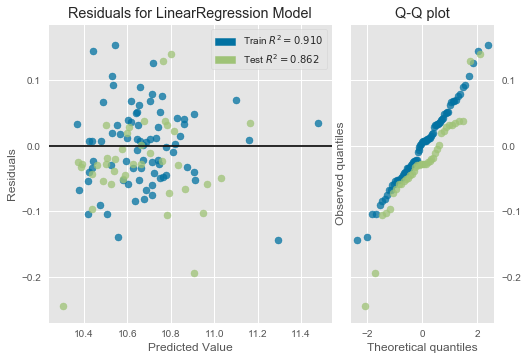

Train Score: 0.9103873472286246
Test Score: 0.86227685638121
---
Train RMSE:  0.06025568888561
Test RMSE:  0.07313219260884866
---
Unlogged Train RMSE:  2784.2721868678227
Unlogged Test RMSE:  3407.8524352770182
---


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      6yr_mean_earnings   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     50.01
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           2.03e-28
Time:                        16:11:50   Log-Likelihood:                 108.44
No. Observations:                  78   AIC:                            -188.9
Df Residuals:                      64   BIC:                            -155.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
const                                                         9.8677      1.738      5.678      0.000       6.396      13.339
avg_annual_cost_attendance                                    0.1406      0.044      3.182      0.002       0.052       0.229
pct_asian                                                     0.0395      0.010      4.019      0.000       0.020       0.059
SAT_AVG                                                       0.0290      0.231      0.126      0.900      -0.432       0.490
Women's Team Average Annual Institutional Salary per FTE4     0.0809      0.050      1.612      0.112      -0.019       0.181
pct_hispanic                                                  0.0146      0.012      1.191      0.238      -0.010       0.039
Football Total Participation                                  0.0990      0.106      0.933      0.354      -0.113       0.311
 Womens_opex_per_participant                                  0.0023      0.031      0.075      0.940      -0.059       0.064
Football Total Revenue                                        0.0008      0.020      0.038      0.970      -0.039       0.041
pct_mid_income_2                                             -0.0631      0.088     -0.720      0.474      -0.238       0.112
pct_women                                                    -0.3368      0.105     -3.207      0.002      -0.547      -0.127
ADM_RATE                                                     -0.1012      0.043     -2.359      0.021      -0.187      -0.015
PELL_EVER                                                    -0.3004      0.061     -4.889      0.000      -0.423      -0.178
median_debt_completers                                       -0.2643      0.055     -4.810      0.000      -0.374      -0.155
==============================================================================
Omnibus:                        0.294   Durbin-Watson:                   1.706
Prob(Omnibus):                  0.863   Jarque-Bera (JB):                0.171
Skew:                          -0.114   Prob(JB):                        0.918
Kurtosis:                       2.978   Cond. No.                     6.46e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
sum_1 = ms_linear_regression(ncaa_grouped_all_merge, id_x_cols = 'yes', cols = coef_col_list_enet)
sum_1

Using the remaining coefficients, our model performed worse in a standard regresion model. Many coefficients are statistically insignificant however, so let's remove those and rerun the regression.

In [91]:
new_cols = ms_sm_reg(sum_1)

14 6
['avg_annual_cost_attendance', 'pct_asian', 'pct_women', 'ADM_RATE', 'PELL_EVER']


In [92]:
ncaa_grouped_all_merge[['1yr_declining_loan_balance','3yr_declining_loan_balance']].corr()

1yr_declining_loan_balance  \
1yr_declining_loan_balance                    1.000000   
3yr_declining_loan_balance                    0.981548   

                            3yr_declining_loan_balance  
1yr_declining_loan_balance                    0.981548  
3yr_declining_loan_balance                    1.000000

In [93]:
#we'll have to remove the declining loan balance coefficients due to high correlation with each other

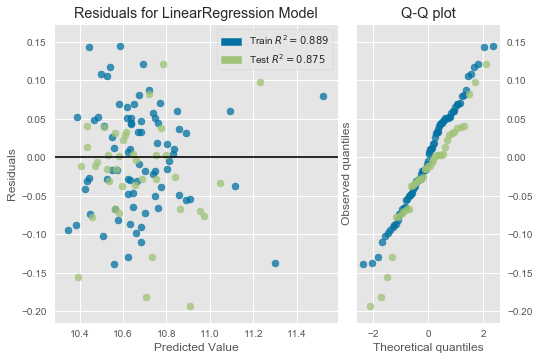

Train Score: 0.8887317982154744
Test Score: 0.875083940134635
---
Train RMSE:  0.06714271891053844
Test RMSE:  0.06964890121681189
---
Unlogged Train RMSE:  3114.6426309195413
Unlogged Test RMSE:  3511.517935097972
---


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      6yr_mean_earnings   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     94.52
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           7.62e-32
Time:                        16:11:50   Log-Likelihood:                 99.996
No. Observations:                  78   AIC:                            -186.0
Df Residuals:                      71   BIC:                            -169.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         10.6763      0.008   1339.833      0.000      10.660      10.692
avg_annual_cost_attendance     0.0488      0.014      3.512      0.001       0.021       0.076
pct_asian                      0.0483      0.009      5.174      0.000       0.030       0.067
pct_women                     -0.0309      0.009     -3.500      0.001      -0.048      -0.013
ADM_RATE                      -0.0435      0.015     -2.957      0.004      -0.073      -0.014
PELL_EVER                     -0.0672      0.010     -6.432      0.000      -0.088      -0.046
median_debt_completers        -0.0595      0.010     -5.691      0.000      -0.080      -0.039
==============================================================================
Omnibus:                        2.205   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.332   Jarque-Bera (JB):                1.452
Skew:                           0.003   Prob(JB):                        0.484
Kurtosis:                       2.332   Cond. No.                         3.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
sum_2 = ms_linear_regression(ncaa_grouped_all_merge, id_x_cols = 'yes', scale = 'yes', cols = new_cols)
sum_2

In [95]:
for col in new_cols:
    print(f"Standard Deviation of {col}: {ncaa_grouped_all_merge[col].std()}")

Standard Deviation of avg_annual_cost_attendance: 10763.611122778164
Standard Deviation of pct_asian: 0.05668133138360794
Standard Deviation of pct_women: 0.04814824936663754
Standard Deviation of ADM_RATE: 0.19697873315451556
Standard Deviation of PELL_EVER: 0.11807630333374189
Standard Deviation of median_debt_completers: 3000.0892111368753


### Model Summary

In this general model, we have 6 remaining coefficients.

These changes are an average when holding all else equal:

- **Average cost of attendance**: a one standard deviation increase in average cost of attendance leads to a 4.88% increase in earnings
- **Percentage of asian students**: 4.83% increase in earnings
- **Percentage of female students**: 3.09% decrease in earnings
- **Pell grant rate**: 6.27% decrease
- **Median debt of 4 year (150% time) completers**: 5.95% decrease in earnings

So, our final model fits more evenly on the train and test set while reducing the test set errors. There are 6 remaining coefficients that have a statistically significant relationship with 6 year average earnings. The coefficient with the largest magnitude is the average annual cost of attendance. A 1 standard deviation increase in cost (10K) leads to a 4.8% increase in average earnings. We may be seeing the impact of added resources that a school may have. This is related to admissions rate. A one standard deviation increase in admission rate (20%) leads to a 4.35% decrease in earnings on average. As schools become less selective, earnings amongst its graduates tend to fall.

In addition, we see that a one standard deviation increase in percentage of women (4.8%) causes average earnings to drop by 3% on average. Women are so vastly underpaid upon graduating that just having more attend the school brings down the average earnings of the entire school. 

We also see the percentage of asian students has a positive impact on earnings, perhaps speaking to how creating a more diverse enviornment can improve outcomes. It could also be the result of asian origin groups earning a much higher median income than the average American household. [Asian households in the U.S. had a median annual income of 85,800 in 2019, higher than the 61,800 among all U.S. households.](https://www.pewresearch.org/fact-tank/2021/04/29/key-facts-about-asian-origin-groups-in-the-u-s/).

## Regressing on Male and Female Earnings

Next, we'll perform the same sort of regression analysis as above, but now using 6 year average male earnings and 6 year average female earnings to get to the bottom of what variables impact each the most.

First, we'll do female earnings.

In [96]:
#elastic_net grid search
e_net_female_cv, cols = ms_elastic_net_cv(ncaa_grouped_all_merge, all_earn = 'no', dep ='6yr_female_mean_earnings')

Train R2: 0.8940470663894027
Test R2: 0.8227895118076635
*****
Train MSE: 0.003736807916718533
Test MSE: 0.005994862753173457
*****
Train RMSE: 0.06112943576312915
Test RMSE: 0.07742649903730284
alpha: 0.100000
l1_ratio_: 0.080000


In [97]:
#elastic_net grid search
e_net_female_coefs_cv = ms_eval_coefficients(e_net_female_cv, cols)

Total number of coefficients:  94
Coefficients close to zero:  77
Intercept: 10.574671257468763


pct_asian                         0.034007
avg_annual_cost_attendance        0.028926
avg_faculty_sal                   0.027343
1yr_declining_loan_balance        0.014726
pct_hispanic                      0.012366
                                    ...   
3_yr_repayment_completers_rate    0.000000
num_female_4yr_completers        -0.001770
ADM_RATE                         -0.021393
median_debt_completers           -0.025741
PELL_EVER                        -0.032960
Length: 94, dtype: float64

In [98]:
ms_repeated_kfolds(ncaa_grouped_all_merge, all_earn = 'no', dep = '6yr_female_mean_earnings')

Train Score: 0.9409185988983838
Test Score: 0.3723815407419303
Train RMSE:  0.04711956541089733
Test RMSE:  0.0732731059130594
est=0.789, cfg={'alpha': 0.1, 'l1_ratio': 0.0, 'max_iter': 1000}
---
Train Score: 0.9190423225087737
Test Score: 0.6998544036843544
Train RMSE:  0.04908108889812425
Test RMSE:  0.13283365525557406
est=0.744, cfg={'alpha': 0.01, 'l1_ratio': 0.30000000000000004, 'max_iter': 100}
---
Train Score: 0.8715450800598272
Test Score: 0.7804815320629157
Train RMSE:  0.06750545260958461
Test RMSE:  0.07958709876612692
est=0.706, cfg={'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 10}
---
Train Score: 0.8771891401383465
Test Score: 0.7364406819313085
Train RMSE:  0.06564523172180431
Test RMSE:  0.09218047354711946
est=0.738, cfg={'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 10}
---
Train Score: 0.8733644945557177
Test Score: 0.8705480090314488
Train RMSE:  0.06633590731375016
Test RMSE:  0.06701343894600405
est=0.709, cfg={'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 100}
---
Train

{'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 100}

In [99]:
#repeated kfolds method
e_net_female_earn, cols = ms_elastic_net(ncaa_grouped_all_merge, alpha = .1, 
                                                    l1_ratio = .1, max_iter = 100 )

Train R2: 0.8982285292673311
Test R2: 0.8918658400767241
*****
Train MSE: 0.004123374956287225
Test MSE: 0.004199263936518192
*****
Train RMSE: 0.06421351069897381
Test RMSE: 0.0648017278821961


In [100]:
e_net_female_coefs_ = ms_eval_coefficients(e_net_female_earn, cols)

Total number of coefficients:  94
Coefficients close to zero:  74
Intercept: 10.676291138768729


avg_annual_cost_attendance    0.029731
avg_faculty_sal               0.023836
pct_asian                     0.022517
1yr_declining_loan_balance    0.021449
tuition_rev_per_student       0.014232
                                ...   
num_female_4yr_completers    -0.009089
pct_women                    -0.009648
PELL_EVER                    -0.025696
ADM_RATE                     -0.027301
median_debt_completers       -0.036677
Length: 94, dtype: float64

The repeated kfolds model performs a bit better, producing nearly identical R2 scores and errors, so we'll use those parameters.

In [101]:
coef_df = pd.DataFrame(e_net_female_coefs_)
coef_df.reset_index(inplace = True)
coef_df.rename(columns = {0:'coef', 'index':'feature'}, inplace = True)

coef_df['remove'] = coef_df.apply(lambda row: abs(row.coef) < 10**(-10), axis = 1)
coef_df = coef_df[coef_df['remove'] == False]

coef_df.set_index('feature', inplace = True)
coef_df.drop(columns = 'remove', inplace = True)

In [102]:
coef_col_list_enet_female = coef_df.index.to_list()

In [103]:
coef_col_list_enet_female

['avg_annual_cost_attendance',
 'avg_faculty_sal',
 'pct_asian',
 '1yr_declining_loan_balance',
 'tuition_rev_per_student',
 'SAT_AVG',
 "Women's Team Average Annual Institutional Salary per FTE4",
 "Basketball Women's Team Expenses",
 'pct_hispanic',
 '3yr_declining_loan_balance',
 '5yr_declining_loan_balance',
 "Total Men's Team Participation",
 ' Womens_opex_per_participant ',
 "Basketball Women's Team Operating Expenses",
 'pct_mid_income_2',
 'num_female_4yr_completers',
 'pct_women',
 'PELL_EVER',
 'ADM_RATE',
 'median_debt_completers']

In [104]:
coef_col_list_enet_female = ['avg_annual_cost_attendance',
 'pct_asian',
 'SAT_AVG',
 "Women's Team Average Annual Institutional Salary per FTE4",
 'pct_hispanic',
 "Total Men's Team Participation",
 ' Womens_opex_per_participant ',
 'pct_mid_income_2',
 'pct_women',
 'PELL_EVER',
 'ADM_RATE',
 'median_debt_completers']

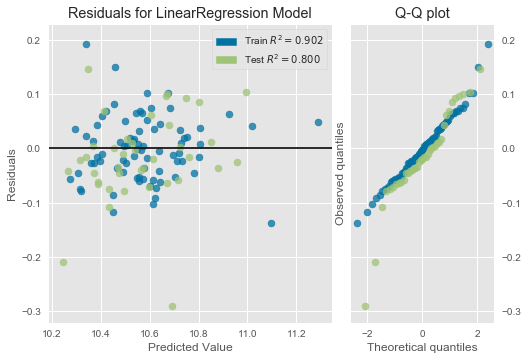

Train Score: 0.9022594069000108
Test Score: 0.8002006342393386
---
Train RMSE:  0.05871260897231817
Test RMSE:  0.0822132778724649
---
Unlogged Train RMSE:  2402.0992316922016
Unlogged Test RMSE:  3504.6941194930787
---


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     6yr_female_mean_earnings   R-squared:                       0.902
Model:                                  OLS   Adj. R-squared:                  0.884
Method:                       Least Squares   F-statistic:                     50.00
Date:                      Fri, 23 Jul 2021   Prob (F-statistic):           4.28e-28
Time:                              16:15:32   Log-Likelihood:                 110.46
No. Observations:                        78   AIC:                            -194.9
Df Residuals:                            65   BIC:                            -164.3
Df Model:                                12                                         
Covariance Type:                  nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
const                                                        10.5747      0.007   1452.085      0.000      10.560      10.589
avg_annual_cost_attendance                                    0.0477      0.015      3.239      0.002       0.018       0.077
pct_asian                                                     0.0532      0.010      5.319      0.000       0.033       0.073
SAT_AVG                                                      -0.0072      0.020     -0.354      0.725      -0.048       0.034
Women's Team Average Annual Institutional Salary per FTE4     0.0228      0.013      1.712      0.092      -0.004       0.049
pct_hispanic                                                  0.0247      0.010      2.532      0.014       0.005       0.044
Total Men's Team Participation                                0.0086      0.011      0.800      0.427      -0.013       0.030
 Womens_opex_per_participant                                 -0.0023      0.011     -0.203      0.840      -0.024       0.020
pct_mid_income_2                                              0.0034      0.009      0.400      0.690      -0.014       0.020
pct_women                                                    -0.0079      0.009     -0.917      0.363      -0.025       0.009
PELL_EVER                                                    -0.0710      0.013     -5.367      0.000      -0.097      -0.045
ADM_RATE                                                     -0.0353      0.018     -1.958      0.054      -0.071       0.001
median_debt_completers                                       -0.0327      0.011     -3.067      0.003      -0.054      -0.011
==============================================================================
Omnibus:                        4.269   Durbin-Watson:                   1.564
Prob(Omnibus):                  0.118   Jarque-Bera (JB):                3.513
Skew:                          -0.403   Prob(JB):                        0.173
Kurtosis:                       3.657   Cond. No.                         7.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
sum_3 = ms_linear_regression(ncaa_grouped_all_merge, all_earn = 'no', scale = 'yes', dep = '6yr_female_mean_earnings',
                             id_x_cols = 'yes', cols = coef_col_list_enet_female)
sum_3

13 5
['avg_annual_cost_attendance', 'pct_asian', 'pct_hispanic', 'PELL_EVER', 'median_debt_completers']


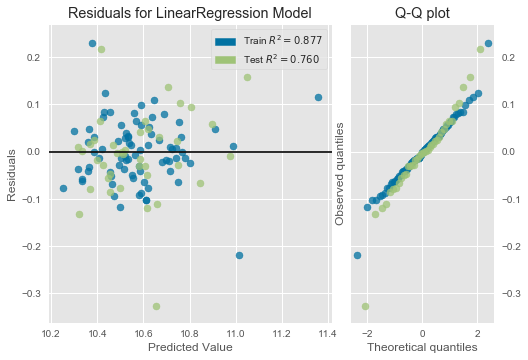

Train Score: 0.8766547526981123
Test Score: 0.7604879752279146
---
Train RMSE:  0.06595612072521342
Test RMSE:  0.090013691460323
---
Unlogged Train RMSE:  2964.862141973967
Unlogged Test RMSE:  4005.3970913934877
---


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     6yr_female_mean_earnings   R-squared:                       0.877
Model:                                  OLS   Adj. R-squared:                  0.868
Method:                       Least Squares   F-statistic:                     102.3
Date:                      Fri, 23 Jul 2021   Prob (F-statistic):           2.69e-31
Time:                              16:15:32   Log-Likelihood:                 101.39
No. Observations:                        78   AIC:                            -190.8
Df Residuals:                            72   BIC:                            -176.6
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         10.5747      0.008   1360.436      0.000      10.559      10.590
avg_annual_cost_attendance     0.0628      0.010      6.206      0.000       0.043       0.083
pct_asian                      0.0647      0.009      7.024      0.000       0.046       0.083
pct_hispanic                   0.0188      0.010      1.962      0.054      -0.000       0.038
PELL_EVER                     -0.0788      0.010     -7.652      0.000      -0.099      -0.058
median_debt_completers        -0.0487      0.009     -5.417      0.000      -0.067      -0.031
==============================================================================
Omnibus:                        6.107   Durbin-Watson:                   1.637
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                9.492
Skew:                          -0.120   Prob(JB):                      0.00869
Kurtosis:                       4.692   Cond. No.                         2.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
new_cols_female = ms_sm_reg(sum_3)

sum_4 = ms_linear_regression(ncaa_grouped_all_merge, all_earn = 'no', scale = 'yes', dep = '6yr_female_mean_earnings',
                             id_x_cols = 'yes', cols = new_cols_female)
sum_4

We're left with fewer coefficients when running the regression on just female earnings. We have 5 remaining: average annual cost of attendance, percent asian, percent hispanic, which are all positive, pell grant rate, and median_debt_completers, which are negative and were also present in the previous earnings regression. So the factors that affect the broader earnings of graduates have similar effects on female-specific earnings.

### 6 year male mean earnings regression

Now let's move on to regression average male earnings.

In [107]:
#grid search
e_net_male_cv, cols = ms_elastic_net_cv(ncaa_grouped_all_merge, all_earn = 'no', dep ='6yr_male_mean_earnings')

Train R2: 0.8858977052465581
Test R2: 0.885501364191666
*****
Train MSE: 0.005200264851695977
Test MSE: 0.004759568538092695
*****
Train RMSE: 0.07211286190199344
Test RMSE: 0.06898962630782034
alpha: 0.100000
l1_ratio_: 0.070000


In [108]:
e_net_male_coefs_cv = ms_eval_coefficients(e_net_male_cv, cols)

Total number of coefficients:  94
Coefficients close to zero:  68
Intercept: 10.774996154173587


avg_annual_cost_attendance    0.024579
1yr_declining_loan_balance    0.023809
pct_asian                     0.017385
avg_faculty_sal               0.016080
tuition_rev_per_student       0.015594
                                ...   
num_female_4yr_completers    -0.011040
pct_women                    -0.011865
PELL_EVER                    -0.023188
ADM_RATE                     -0.033600
median_debt_completers       -0.047290
Length: 94, dtype: float64

In [109]:
ms_repeated_kfolds(ncaa_grouped_all_merge, all_earn = 'no', dep = '6yr_male_mean_earnings')

Train Score: 0.9389020902012168
Test Score: -1.3449735117305157
Train RMSE:  0.05407919775418733
Test RMSE:  0.11353895996745102
est=0.778, cfg={'alpha': 0.01, 'l1_ratio': 0.2, 'max_iter': 100}
---
Train Score: 0.8641826164921715
Test Score: 0.8888254081464156
Train RMSE:  0.07186877416991137
Test RMSE:  0.09501260968999306
est=0.710, cfg={'alpha': 1, 'l1_ratio': 0.0, 'max_iter': 100}
---
Train Score: 0.8818212478957853
Test Score: 0.8441681309356999
Train RMSE:  0.07294987967678652
Test RMSE:  0.07642422755491489
est=0.688, cfg={'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 100}
---
Train Score: 0.8800667014931102
Test Score: 0.928185865715288
Train RMSE:  0.0738321223098303
Test RMSE:  0.047445021398179764
est=0.715, cfg={'alpha': 1, 'l1_ratio': 0.0, 'max_iter': 1000}
---
Train Score: 0.8849467534779593
Test Score: 0.8482537905416779
Train RMSE:  0.07127665810284584
Test RMSE:  0.08270553655104715
est=0.660, cfg={'alpha': 1, 'l1_ratio': 0.0, 'max_iter': 100}
---
Train Score: 0.898489792

{'alpha': 0.1, 'l1_ratio': 0.0, 'max_iter': 1000}

In [110]:
e_net_male_earn_kfold, cols = ms_elastic_net(ncaa_grouped_all_merge, alpha = .01, 
                                                    l1_ratio = 0.6, max_iter = 10)

Train R2: 0.918394659570239
Test R2: 0.89792433684294
*****
Train MSE: 0.003306323615104794
Test MSE: 0.0039639892832732445
*****
Train RMSE: 0.05750064012778287
Test RMSE: 0.06296021984772007


In [111]:
e_net_male_coefs_kfold = ms_eval_coefficients(e_net_male_earn_kfold, cols)

Total number of coefficients:  94
Coefficients close to zero:  66
Intercept: 10.676291138768729


avg_annual_cost_attendance                                   0.037179
pct_asian                                                    0.031417
1yr_declining_loan_balance                                   0.024510
SAT_AVG                                                      0.020485
Women's Team Average Annual Institutional Salary per FTE4    0.017503
                                                               ...   
Grand Total Expenses                                        -0.008627
pct_women                                                   -0.013931
PELL_EVER                                                   -0.026522
ADM_RATE                                                    -0.030548
median_debt_completers                                      -0.047204
Length: 94, dtype: float64

Elastic Net with kfolds has a stronger fit and smaller errors, so we'll use those coefficients.

In [112]:
coef_df = pd.DataFrame(e_net_male_coefs_kfold)
coef_df.reset_index(inplace = True)
coef_df.rename(columns = {0:'coef', 'index':'feature'}, inplace = True)

coef_df['remove'] = coef_df.apply(lambda row: abs(row.coef) < 10**(-10), axis = 1)
coef_df = coef_df[coef_df['remove'] == False]

coef_df.set_index('feature', inplace = True)
coef_df.drop(columns = 'remove', inplace = True)

In [113]:
coef_col_list_enet_male = coef_df.index.to_list()

In [114]:
coef_col_list_enet_male

['avg_annual_cost_attendance',
 'pct_asian',
 '1yr_declining_loan_balance',
 'SAT_AVG',
 "Women's Team Average Annual Institutional Salary per FTE4",
 'tuition_rev_per_student',
 'avg_faculty_sal',
 'LOAN_EVER',
 'Football Total Revenue',
 'pct_hispanic',
 'Football Total Participation',
 'pct_men',
 ' Womens_opex_per_participant ',
 '5yr_declining_loan_balance',
 "Basketball Women's Team Operating Expenses",
 "Men's Team Average Annual Institutional Salary per Assistant Coach",
 "Total Women's Team Operating Expenses",
 'Grand Total Revenue',
 'fed_loan_rate',
 'avg_net_price_private',
 'num_female_4yr_completers',
 'num_4yr_completers',
 'pct_mid_income_2',
 'Grand Total Expenses',
 'pct_women',
 'PELL_EVER',
 'ADM_RATE',
 'median_debt_completers']

In [115]:
#dropping some correlated columns
coef_col_list_enet_male = ['avg_annual_cost_attendance',
 'pct_asian',
 'SAT_AVG',
 "Women's Team Average Annual Institutional Salary per FTE4",
 'avg_faculty_sal',
 'LOAN_EVER',
 'Football Total Revenue',
 'pct_hispanic',
 'Football Total Participation',
 ' Womens_opex_per_participant ',
 'fed_loan_rate',
 'num_female_4yr_completers',
 'pct_mid_income_2',
 'Grand Total Expenses',
 'pct_women',
 'PELL_EVER',
 'ADM_RATE',
 'median_debt_completers']

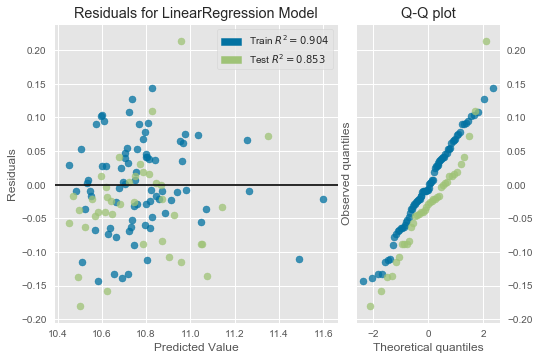

Train Score: 0.9043603909064283
Test Score: 0.8527830495307882
---
Train RMSE:  0.06602135574496383
Test RMSE:  0.07822805726769562
---
Unlogged Train RMSE:  3294.807623825241
Unlogged Test RMSE:  4067.9017925925427
---


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     6yr_male_mean_earnings   R-squared:                       0.904
Model:                                OLS   Adj. R-squared:                  0.875
Method:                     Least Squares   F-statistic:                     30.99
Date:                    Fri, 23 Jul 2021   Prob (F-statistic):           1.70e-23
Time:                            16:19:23   Log-Likelihood:                 101.31
No. Observations:                      78   AIC:                            -164.6
Df Residuals:                          59   BIC:                            -119.8
Df Model:                              18                                         
Covariance Type:                nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
const                                                        10.7750      0.009   1253.599      0.000      10.758      10.792
avg_annual_cost_attendance                                    0.0420      0.017      2.484      0.016       0.008       0.076
pct_asian                                                     0.0193      0.015      1.248      0.217      -0.012       0.050
SAT_AVG                                                      -0.0108      0.031     -0.353      0.726      -0.072       0.050
Women's Team Average Annual Institutional Salary per FTE4     0.0272      0.018      1.531      0.131      -0.008       0.063
avg_faculty_sal                                               0.0337      0.022      1.512      0.136      -0.011       0.078
LOAN_EVER                                                     0.0388      0.022      1.737      0.088      -0.006       0.084
Football Total Revenue                                        0.0381      0.026      1.462      0.149      -0.014       0.090
pct_hispanic                                                  0.0036      0.013      0.285      0.777      -0.022       0.029
Football Total Participation                                  0.0099      0.010      0.983      0.329      -0.010       0.030
 Womens_opex_per_participant                                  0.0012      0.015      0.081      0.935      -0.029       0.032
fed_loan_rate                                                -0.0395      0.024     -1.673      0.100      -0.087       0.008
num_female_4yr_completers                                    -0.0068      0.016     -0.416      0.679      -0.040       0.026
pct_mid_income_2                                             -0.0182      0.010     -1.733      0.088      -0.039       0.003
Grand Total Expenses                                         -0.0512      0.022     -2.340      0.023      -0.095      -0.007
pct_women                                                    -0.0296      0.011     -2.805      0.007      -0.051      -0.008
PELL_EVER                                                    -0.0386      0.021     -1.835      0.072      -0.081       0.003
ADM_RATE                                                     -0.0493      0.023     -2.180      0.033      -0.095      -0.004
median_debt_completers                                       -0.0649      0.016     -3.955      0.000      -0.098      -0.032
==============================================================================
Omnibus:                        1.208   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.547   Jarque-Bera (JB):                1.163
Skew:                         

In [116]:
sum_5 = ms_linear_regression(ncaa_grouped_all_merge, all_earn = 'no', scale = 'yes',dep = '6yr_male_mean_earnings',
                             id_x_cols = 'yes', cols = coef_col_list_enet_male)
sum_5

19 5
['avg_annual_cost_attendance', 'Grand Total Expenses', 'pct_women', 'ADM_RATE', 'median_debt_completers']


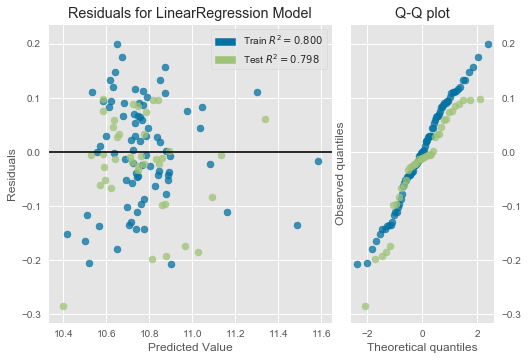

Train Score: 0.8001605826570295
Test Score: 0.7976707219835132
---
Train RMSE:  0.0954346575627781
Test RMSE:  0.0917092205403211
---
Unlogged Train RMSE:  4700.30508775541
Unlogged Test RMSE:  4794.775364046929
---


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     6yr_male_mean_earnings   R-squared:                       0.800
Model:                                OLS   Adj. R-squared:                  0.786
Method:                     Least Squares   F-statistic:                     57.66
Date:                    Fri, 23 Jul 2021   Prob (F-statistic):           8.25e-24
Time:                            16:19:23   Log-Likelihood:                 72.569
No. Observations:                      78   AIC:                            -133.1
Df Residuals:                          72   BIC:                            -119.0
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         10.7750      0.011    958.026      0.000      10.753      10.797
avg_annual_cost_attendance     0.0815      0.018      4.527      0.000       0.046       0.117
Grand Total Expenses           0.0378      0.013      2.911      0.005       0.012       0.064
pct_women                     -0.0410      0.012     -3.342      0.001      -0.066      -0.017
ADM_RATE                      -0.0586      0.021     -2.855      0.006      -0.100      -0.018
median_debt_completers        -0.0667      0.014     -4.623      0.000      -0.095      -0.038
==============================================================================
Omnibus:                        3.489   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                2.200
Skew:                           0.196   Prob(JB):                        0.333
Kurtosis:                       2.276   Cond. No.                         3.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [117]:
new_cols_male = ms_sm_reg(sum_5)

sum_6 = ms_linear_regression(ncaa_grouped_all_merge, all_earn = 'no', scale = 'yes', dep = '6yr_male_mean_earnings',
                             id_x_cols = 'yes', cols = new_cols_male)
sum_6

In [118]:
ncaa_grouped_all_merge[['avg_annual_cost_attendance', 'ADM_RATE']].corr()

avg_annual_cost_attendance  ADM_RATE
avg_annual_cost_attendance                    1.000000 -0.659158
ADM_RATE                                     -0.659158  1.000000

Once again, we see almost the same group of coefficients for the regression with male earnings. This model though has larger errors and would do a poorer job at predicting average earnings.

Interestingly, we see grand total expenses, which is what the school spent on sports. The coefficient has a positive effect on earnings. For a one standard deviation increase in what a school spends on sports, average male earnings increases by 3.8%. One reason could be that schools which spend more on sports produce more professional athletes, who drive up average earnings. It could also be a proxy for school resources, but it is curious that it's only affecting men's earnings and not women's.

### Demographics-Agnostic Regression

Lastly, we'll run a regression that excludes demographic data. We saw that the demographics of a school have large impacts on average earnings of graduates. This has more to do with structural societal trends than the actual school. No matter where a female student graduates from, she'll likely make less than her male peers. A similar statement can be made about asian graduates - they're much more likely to earn more than the average student. To attempt to isolate just the effects driven by the schools, I'll remove the demographic data and rerun the regression on 6 year average earnings.

In [119]:
ncaa_grouped_all_merge_no_demo = ncaa_grouped_all_merge.drop(columns = ['pct_asian', 'pct_hispanic', 'pct_women', 'pct_white',
                                                                       'pct_black','3yr_declining_loan_balance',
                                                                       '5yr_declining_loan_balance', 'pct_men'])

In [120]:
e_net_cv, cols = ms_elastic_net_cv(ncaa_grouped_all_merge_no_demo)

Train R2: 0.8933830693845575
Test R2: 0.8406682988951835
*****
Train MSE: 0.004319693706409302
Test MSE: 0.006187460714248668
*****
Train RMSE: 0.06572437680502799
Test RMSE: 0.07866041389573708
alpha: 0.010000
l1_ratio_: 0.790000


In [121]:
e_net_coefs_cv_no_demo = ms_eval_coefficients(e_net_cv, cols)

Total number of coefficients:  86
Coefficients close to zero:  74
Intercept: 10.676291138768727


avg_faculty_sal                                              0.045186
avg_annual_cost_attendance                                   0.040648
1yr_declining_loan_balance                                   0.035901
Women's Team Average Annual Institutional Salary per FTE4    0.013878
tuition_rev_per_student                                      0.010558
                                                               ...   
3_yr_repayment_completers_rate                               0.000000
pct_mid_income_2                                            -0.002300
ADM_RATE                                                    -0.026469
PELL_EVER                                                   -0.030444
median_debt_completers                                      -0.045611
Length: 86, dtype: float64

In [122]:
coef_df = pd.DataFrame(e_net_coefs_cv_no_demo)
coef_df.reset_index(inplace = True)
coef_df.rename(columns = {0:'coef', 'index':'feature'}, inplace = True)

coef_df['remove'] = coef_df.apply(lambda row: abs(row.coef) < 10**(-10), axis = 1)
coef_df = coef_df[coef_df['remove'] == False]

coef_df.set_index('feature', inplace = True)
coef_df.drop(columns = 'remove', inplace = True)

In [123]:
coef_col_list_enet_nodemo = coef_df.index.to_list()

In [124]:
coef_col_list_enet_nodemo

['avg_faculty_sal',
 'avg_annual_cost_attendance',
 '1yr_declining_loan_balance',
 "Women's Team Average Annual Institutional Salary per FTE4",
 'tuition_rev_per_student',
 'Football Total Participation',
 ' Womens_opex_per_participant ',
 'REGION',
 'pct_mid_income_2',
 'ADM_RATE',
 'PELL_EVER',
 'median_debt_completers']

In [125]:
coef_col_list_enet_nodemo = ['avg_faculty_sal',
 'avg_annual_cost_attendance',
 '1yr_declining_loan_balance',
 'Football Total Participation',
 ' Womens_opex_per_participant ',
 'REGION',
 'pct_mid_income_2',
 'ADM_RATE',
 'PELL_EVER',
 'median_debt_completers']

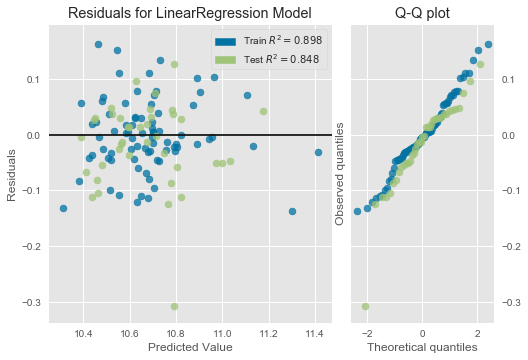

Train Score: 0.8977707326304522
Test Score: 0.8482872603919495
---
Train RMSE:  0.06435777384310198
Test RMSE:  0.07675667550020915
---
Unlogged Train RMSE:  2948.4563603295082
Unlogged Test RMSE:  3870.895133943895
---


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      6yr_mean_earnings   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     58.84
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           3.04e-29
Time:                        16:19:28   Log-Likelihood:                 103.30
No. Observations:                  78   AIC:                            -184.6
Df Residuals:                      67   BIC:                            -158.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            10.6763      0.008   1357.866      0.000      10.661      10.692
avg_faculty_sal                   0.0537      0.014      3.798      0.000       0.025       0.082
avg_annual_cost_attendance        0.0500      0.015      3.271      0.002       0.019       0.081
1yr_declining_loan_balance        0.0395      0.015      2.675      0.009       0.010       0.069
Football Total Participation      0.0135      0.009      1.450      0.152      -0.005       0.032
 Womens_opex_per_participant      0.0095      0.009      1.017      0.313      -0.009       0.028
REGION                            0.0088      0.011      0.783      0.437      -0.014       0.031
pct_mid_income_2                 -0.0089      0.009     -0.979      0.331      -0.027       0.009
ADM_RATE                         -0.0218      0.016     -1.387      0.170      -0.053       0.010
PELL_EVER                        -0.0422      0.014     -3.021      0.004      -0.070      -0.014
median_debt_completers           -0.0488      0.012     -3.978      0.000      -0.073      -0.024
==============================================================================
Omnibus:                        0.677   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.713   Jarque-Bera (JB):                0.473
Skew:                          -0.191   Prob(JB):                        0.790
Kurtosis:                       3.006   Cond. No.                         5.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
sum_7 = ms_linear_regression(ncaa_grouped_all_merge,
                             id_x_cols = 'yes', scale = 'yes', cols = coef_col_list_enet_nodemo)
sum_7

11 5
['avg_faculty_sal', 'avg_annual_cost_attendance', '1yr_declining_loan_balance', 'PELL_EVER', 'median_debt_completers']


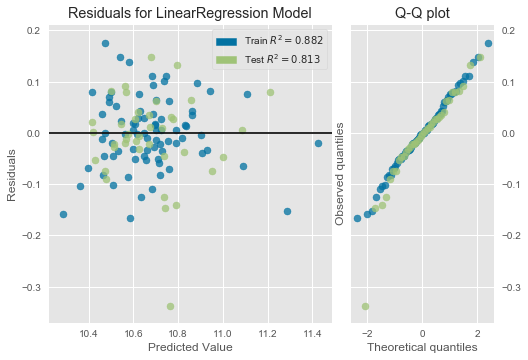

Train Score: 0.8820113939074932
Test Score: 0.8132467463145866
---
Train RMSE:  0.06914064462301
Test RMSE:  0.08516069935705092
---
Unlogged Train RMSE:  3134.7621178209406
Unlogged Test RMSE:  4318.967989665926
---


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      6yr_mean_earnings   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     107.6
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           5.49e-32
Time:                        16:19:29   Log-Likelihood:                 97.709
No. Observations:                  78   AIC:                            -183.4
Df Residuals:                      72   BIC:                            -169.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         10.6763      0.008   1310.247      0.000      10.660      10.693
avg_faculty_sal                0.0618      0.013      4.735      0.000       0.036       0.088
avg_annual_cost_attendance     0.0627      0.011      5.553      0.000       0.040       0.085
1yr_declining_loan_balance     0.0351      0.013      2.604      0.011       0.008       0.062
PELL_EVER                     -0.0381      0.013     -2.951      0.004      -0.064      -0.012
median_debt_completers        -0.0609      0.010     -6.275      0.000      -0.080      -0.042
==============================================================================
Omnibus:                        0.185   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.912   Jarque-Bera (JB):                0.009
Skew:                           0.020   Prob(JB):                        0.995
Kurtosis:                       3.035   Cond. No.                         3.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
new_cols_nodemo = ms_sm_reg(sum_7)

sum_8 = ms_linear_regression(ncaa_grouped_all_merge, scale = 'yes',
                             id_x_cols = 'yes', cols = new_cols_nodemo)
sum_8

## Model Evaluation

The main goal of this analysis was to find what features about a school - things like demographics, sports and academic expenditures, loan rates and debt totals - have the largest impact on average earnings of graduates, 6 years after they first enrolled. This was not a typical machine learning project where we focused on how accurately we can predict earnings, but rather more of a statistical analysis to help determine what drives changes in earnings.

In this section however, I did want to call out the performance of our predictive models. The model with the best predictive power was the **Ridge Regression** model, using the remaining coefficients after running the dataset through a Lasso Regression model: 

**Ridge Model**

- Train R2: 0.9458398454724065
- Test R2: 0.9000704286141612
*****
- Train MSE: 0.0021943539107766663
- Test MSE: 0.0038806483132620842
*****
- Train RMSE: 0.04684393141887929
- Test RMSE: 0.06229484981330386



The Ridge model produced the smallest error term and had a very even fit on both the train and test data. This model contained 39 coefficients.

The 2nd best model was the **Elastic Net Grid Search** model, which has the benefit of combining both Ridge and Lasso penalties:

**Elastic Net Grid Search**

- Train R2: 0.9072072159359033
- Test R2: 0.9001394280336424
*****
- Train MSE: 0.0037595943065333237
- Test MSE: 0.0038779688013106947
*****
- Train RMSE: 0.06131553071231891
- Test RMSE: 0.06227333941030218
*****
- alpha: 0.100000
- l1_ratio_: 0.070000

This model had a more even fit than the Ridge model, but the error terms were slighlty higher. What makes the Elastic Net model so useful is that you do not need to run a Lasso Regression first, and then feed the remaining coefficients into the model. It zeroes out coefficients on its own, creating a more streamlined process. Using either model would result in accurate predictions of future earnings.

## Conclusion

Having removed demographics data from the final model, I've tried to isolate what school-specific effects there are on earnings. The percentage of women at a school will bring down average earnings because women earn less than men when entering the job market, for example.

In this isolated model, we have 5 remaining coefficients.

These changes are an average when holding all else equal:

- **Average faculty salary**: a one standard deviation increase in faculty salary leads to a 6.18% increase in earnings
- **Average cost of attendance**: 6.27% increase in earnings
- **Percentage of students who have a declining balance after 1 year post-grad**: 3.5% increase in earnings
- **Percentage of students who were on a pell grant**: 3.81% decrease in earnings
- **Median debt of 4 year (150% time) completers**: 6.1% decrease in earnings

These coefficients, although few in number, are valuable pieces of information. They can also be proxies for other features about a school. Average faculty salary and cost of attendance speak to the resources a school has. The higher the cost, the more money there is to pay for the best instructional talent. The percentage of students who have a declining loan balance after 1 year points to how effective graduates are at getting jobs and earning a decent salary. Students earning more after graduation are more likely to pay off more of their debt. As the debt load increases however, we see that this is associated with lower average earnings. More debt hamstrings graduates, and may force them to take a less desirable job simply so they can begin to make payments.

Taking a look at the first model which included demographic data, it was striking to see to what extent the percentage of women at a school has on average earnings 6 years from enrollment. The fact that an increase of 4.8% in the number of women at a school can reduce average earnings by over 3% speaks to how women are facing a constant uphill battle when it comes to pay.

As we saw at the top of the notebook, Duke graduates produced the highest average male and female earnings. However, the average male at Duke earned nearly 112K 6 years from enrollment, while the average female earned only 76K. This is structural inequality that cannot be solved by any one school's actions.

In the end, we found that college sports expenditures do not have a statistically significant relationship with earnings, at least in the models we looked at. However, we were able to identify some schools, like Alabama, Ohio State, Penn State, and Florida State, which spend far more on sports than their peers, but produce worse student outcomes. There is clearly a balance that a school can strike between funding a profitable and lucrative sports program, and investing enough in academics to ensure the success of its student body.

### Future Work

Further analysis would focus on schools that spend higher than average amounts on sports but produce below average earnings outcomes. How does their academic spending compare to their peers who produce better earnings outcomes? What areas of performance are they falling behind? The datasets used here were very detailed when it came to sports expenditures, but less so on academic spending. I'd like to find more detailed academic data to see which areas have the largest effects on earnings.

Additionally, I want access to more current data. Because they latest earnings were from 2014-15, this meant the students whose earnings we have started college back in 08-09 or 09-10. Much about the economy has changed over the last 10 years, and it would be illustrative to look at these same features but with newer data points.

Lastly, I want to figure out how to tune the model even further in a way that might preserve more features. However, it appears as if many features about a school just don't have big effects on earnings. As we saw with female earnings, so much of what you make at your job comes down to luck and societal problems that aren't easily fixable.